In [3]:
import pandas as pd
import datetime as datetime_1
from datetime import datetime as datetime_2
# 导入因子函数库
from jqfactor import get_factor_values
# 导入基本财务信息函数库
from jqdata import *
import warnings
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('stragy_momentum')
class stragy_momentum():
    def __init__(self):
        self.stocks_buy = [] # 待购买列表
        self.day = 0 # 策略运行天数
        self.maxholdstk = 3 # 最大持仓股票数
        self.fundmental_step = 30 # 财务股票池更新频率
        self.technology_step = 5 # 技术股票池更新频率
        self.init_cash = 100000 # 初始资金
        self.cash = self.init_cash #资金
        self.loss_control = BOLLLoss() #增加布林通道止损
        self.positions = {} #持仓情况
        self.account_share = 0 #账户份额
        self.account_value = 0 #账户市值
        self.records = [] #仓位情况
        self.choose_stock = [] #仓位情况
        self.nav = 0 #净值

    '''计算可购买股票数，下取整'''
    def _round_down(self, num, scale=100):
        stock_num = math.floor(num / scale) * scale
        return stock_num
    
    def compute_nav(self, cunrrent_date):
        stock_share = 0
        for key in  self.positions.keys():
            price = self.get_stock_base_data(key, end_date=cunrrent_date, count=1)['open'].values[0]  # 获取股票价格
            stock_share += self.positions[key] * price
        self.account_share = stock_share
        self.nav = self.account_share / self.init_cash  # 计算净值

    '''获取仓位明细'''
    def get_record(self):
        df = pd.DataFrame(self.records, columns=['date', 'cach', 'account_share', 'account_value', 'nav'])
        df.set_index('date', inplace=True)
        df.index = pd.to_datetime(df.index)
        return df
    
    def get_choose_stock_record(self):
        df = pd.DataFrame(self.choose_stock, columns=['date', 'stocks'])
        df.set_index('date', inplace=True)
        df.index = pd.to_datetime(df.index)
        return df

    '''df 列之间比较'''
    def compare_serice(self, serice_1, serice_2, flag):
        if flag == 'max':
            compare_flag = (serice_1 > serice_2)
            serice_2[compare_flag] = serice_1[compare_flag]
            return serice_2
        if flag == 'min':
            compare_flag = (serice_1 < serice_2)
            serice_2[compare_flag] = serice_1[compare_flag]
            return serice_2

    '''获取股票量价'''
    def get_stock_base_data(self, stock, start_date=None, end_date = None,  frequency='daily', panel = False, count = None):
        stock_base_data = get_price(stock, start_date=start_date, end_date=end_date, frequency=frequency,
                          fields=['open', 'close', 'low', 'high', 'avg', 'pre_close'],
                          skip_paused=False, fq='pre', count=count, panel=False)
        return stock_base_data

    '''获取股票因子数据'''
    def get_factor_values_local(self, stock_list, factors, start_date=None, end_date=None, frequence=None, count=None):
        stock_list = list(stock_list)
        if frequence == None:
            return get_factor_values(stock_list, ['operating_profit_growth_rate', 'net_operate_cash_flow_to_net_debt'],
                                     start_date=start_date, end_date=end_date, count=count)
        if frequence == 'year':
            factor_rerurns = {}
            for n in range(int(count)):
                end_date = datetime_2.strptime(end_date, '%Y-%m-%d') - datetime_1.timedelta(365 * int(n))
                end_date = end_date.strftime('%Y-%m-%d')
                return_factor = get_factor_values(stock_list,factors=['operating_profit_growth_rate','net_operate_cash_flow_to_net_debt'],
                                                  start_date=start_date, end_date=end_date, count=1)
                
                factor = pd.DataFrame(index=stock_list)
                for i in return_factor.keys():
                    factor[i] = return_factor[i].iloc[0, :]
                factor_rerurns[end_date] = factor
            return factor_rerurns

    '''下单操作'''
    def order_target(self, stock, amount, cunrrent_date):
        price = self.get_stock_base_data(stock, end_date=cunrrent_date, count=1)['open'].values[0]#获取股票价格
        if amount > 0:
            stock_num = self._round_down(amount / price)
            logger.info('开始下单，日期{}购买股票:{}:股票数量{},股票价格:{}'.format(cunrrent_date, stock, stock_num, price))
            share_amount = round(stock_num * price, 0)
            self.positions[stock] = share_amount / price
            self.account_share += share_amount
            self.cash -= share_amount
            self.account_value = self.account_share + self.cash
        if amount == 0:
            logger.info('开始下单，日期{}卖出股票:{}:股票数量{},股票价格:{}'.format(cunrrent_date, stock, self.positions[stock], price))
            share_amount = self.positions[stock] * price
            self.cash += share_amount
            self.account_share -= share_amount
            self.account_value = self.account_share + self.cash
            del self.positions[stock]

    '''财务因子选股策略'''
    def stragy_choose_stock_financial_factor(self, cunrrent_date, stock_list):
        cunrrent_date = cunrrent_date.strftime('%Y-%m-%d')  # 时间格式转换
        q = query(valuation.code, valuation.day, valuation.pe_ratio, valuation.pb_ratio).filter(
            valuation.code.in_(stock_list), valuation.market_cap > 150)
        fundamental_data = get_fundamentals(query_object=q, date=cunrrent_date, statDate=None)  # 获取财务数据
        
        self.stocks_buy = list(fundamental_data['code'])
        '''
        factor_data_list = self.get_factor_values_local(fundamental_data['code'], ['operating_profit_growth_rate','net_operate_cash_flow_to_net_debt'],
                                                   end_date=cunrrent_date, frequence='year', count='3') # 营业利润增长率、经营活动产生现金流量净额/净债务

        factor_df = pd.DataFrame(index=stock_list, columns=['operating_profit_growth_rate', 'net_operate_cash_flow_to_net_debt'])
        #count = 0
        for i in factor_data_list.keys():
            factor_df['operating_profit_growth_rate'] = factor_df['operating_profit_growth_rate'].fillna(0) + factor_data_list[i]['operating_profit_growth_rate'].astype('float64') 
            factor_df['net_operate_cash_flow_to_net_debt'] =factor_df['net_operate_cash_flow_to_net_debt'].fillna(0) + factor_data_list[i]['net_operate_cash_flow_to_net_debt'].astype('float64') 
        factor_df['operating_profit_growth_rate'] = factor_df['operating_profit_growth_rate'] / 3
        factor_df['net_operate_cash_flow_to_net_debt'] = factor_df['net_operate_cash_flow_to_net_debt'] / 3
        factor_df = factor_df[factor_df['operating_profit_growth_rate'] > 0.5]
        self.stocks_buy = list(factor_df.index)
        '''

    '''技术因子选股策略，该策略以股价振幅为核心，配合成交量为佐证，缺陷是不能过滤股票下跌强势的股票'''
    def stragy_choose_stock_momentum_factor(self, cunrrent_date):

        price = get_price(self.stocks_buy, start_date=None, end_date=cunrrent_date, frequency='daily',
                          fields=['open', 'close', 'low', 'high', 'avg', 'pre_close', 'volume'],
                          skip_paused=False, fq='pre', count=250, panel=True) #获取量价数据
        '''数据简单清洗'''
        open_price = price.loc['open', :, :].dropna(axis=1, how='any')
        close = price.loc['close', :, :].dropna(axis=1, how='any')
        low = price.loc['low', :, :].dropna(axis=1, how='any')
        high = price.loc['high', :, :].dropna(axis=1, how='any')
        prev_close = price.loc['pre_close', :, :].dropna(axis=1, how='any')
        volume = price.loc['volume', :, :].dropna(axis=1, how='any')

        '''获取波动最大值'''
        data_max = self.compare_serice((high - low), (pd.Series.abs(close.shift() - high)), 'max')
        data_max = self.compare_serice(data_max, (pd.Series.abs(close.shift() - low)), 'max')
        alpha_1 = data_max.rolling(window=6).mean().iloc[-1, :].dropna()

        '''获取当日收盘幅度与最近滑动均振幅的比值，并进行百分之排序（统一量纲）'''
        data_range = ((close - low.rolling(window=12).min()) / (
                (high.rolling(window=12).max()) - low.rolling(window=12).min())).rank(axis=0, pct=True)

        '''#获取成交量百分比排序（统一量纲）'''
        volume_rank = volume.rank(axis=0, pct=True)

        '''获取相关系数，与强势程度成反比'''
        alpha_2 = -(data_range.iloc[-6:, :].corrwith(volume_rank.iloc[-6:, :])).dropna()

        alpha = alpha_2 + alpha_1 #两个指标加权
        self.stocks_buy = list(alpha.sort_values().iloc[-self.maxholdstk:].index)
     
    '''计算基准'''
    def computor_benchmark_nav(self, index_code, start_date=None, end_date=None, count=None):
        benchmark_data = stragy_m.get_stock_base_data('399006.XSHE', start_date=start_date, end_date=end_date)['close']
        benchmark_nav = benchmark_data / benchmark_data[0]
        return  benchmark_nav
    
    def get_stocks_condition(self, date = None, condition = '300'):
        stocks_list = get_all_securities(types=['stock'], date=date)
        stock_code = stocks_list.index
        condition_stocks = [code for code in stock_code if code[0:3] == condition]
        return condition_stocks
    
    '''止损函数：布林止损'''
    def stop_hold_stocks(previous_date):
        for code in list(self.positions.keys()):
            if g.loss_control.check(code, previous_date):
                self.order_target(code, 0)

    '''开市前操作'''
    def before_trading(self, cunrrent_date, stock_list):
        
        stop_hold_stocks(cunrrent_date)#止损
        if self.day % self.fundmental_step == 0: #财务因子选股
            self.stragy_choose_stock_financial_factor(cunrrent_date, stock_list)
        if self.day % self.technology_step == 0: #技术因子选股
            self.stragy_choose_stock_momentum_factor(cunrrent_date)
        self.choose_stock.append((cunrrent_date, self.stocks_buy))
        logger.info('日期{}选股股票:{}'.format(cunrrent_date, self.stocks_buy))

    '''开市操作'''
    def handle_bar(self, cunrrent_date):
        if self.day % self.technology_step == 0:
            holdstock = list(self.positions.keys())  # 获取持仓股票
            logger.info('日期{}持仓股票:{}'.format(cunrrent_date, holdstock))
            for s in holdstock:
                if s not in self.stocks_buy:
                    self.order_target(s, 0, cunrrent_date)
            for s in self.stocks_buy:
                if s not in holdstock:
                    self.order_target(s, self.init_cash / self.maxholdstk, cunrrent_date)

    '''闭市后操作'''
    def after_trading(self, cunrrent_date):
        self.day += 1
        logger.info('第{}天闭市，开始计算仓位和净值:'.format(self.day))
        self.compute_nav(cunrrent_date)  # 计算净值
        logger.info('净值{}:'.format(self.nav))
        logger.info('持仓情况，日期:{},账户份额:{},账户市值;{},净值:{}'.format(cunrrent_date, self.account_share, self.account_value, self.nav))
        self.records.append((cunrrent_date, self.cash, self.account_share, self.account_value, self.nav))
        logger.info('第{}天闭市，仓位和净值计算并记录完毕:'.format(self.day))

In [1]:
'''止损函数：布林止损,价格下穿中线'''
class BOLLLoss():
    def check(self, code, previous_date):
        bar = attribute_history(code, count=2)
        price = bar.close[-1]
        last_price = bar.close[-2]
        upperband, middleband, lowerband = Bollinger_Bands(code, check_date= previous_date, timeperiod=20, nbdevup=2, nbdevdn=2)
        if last_price > middleband[code] and price < middleband[code]:
            return True
        return False
    def update(self, code, price):
        pass

In [8]:
stragy_m = stragy_momentum()
start_date = '2012-07-01'
end_date = '2020-05-08'
benchmark_index = '399006.XSHE'
df_data = get_price('000001.XSHG', start_date=start_date, end_date=end_date)
#stock_list = get_index_stocks(benchmark_index, end_date)

trade_date_list = df_data.index
for cunrrent_date in trade_date_list:
    stock_list = stragy_m.get_stocks_condition(date = cunrrent_date)
    stragy_m.before_trading(cunrrent_date, stock_list)
    stragy_m.handle_bar(cunrrent_date + datetime_1.timedelta(1))
    stragy_m.after_trading(cunrrent_date + datetime_1.timedelta(1))
record_data = stragy_m.get_record()
stragy_m.computor_benchmark_nav(benchmark_index,start_date, end_date)

2020-05-31 15:37:00,848 - stragy_momentum - INFO - 日期2012-07-02 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:00,849 - stragy_momentum - INFO - 日期2012-07-03 00:00:00持仓股票:[]
2020-05-31 15:37:00,852 - stragy_momentum - INFO - 开始下单，日期2012-07-03 00:00:00购买股票:300070.XSHE:股票数量5100,股票价格:6.48
2020-05-31 15:37:00,854 - stragy_momentum - INFO - 第1天闭市，开始计算仓位和净值:
2020-05-31 15:37:00,857 - stragy_momentum - INFO - 净值0.33048:
2020-05-31 15:37:00,858 - stragy_momentum - INFO - 持仓情况，日期:2012-07-03 00:00:00,账户份额:33048.0,账户市值;100000.0,净值:0.33048
2020-05-31 15:37:00,858 - stragy_momentum - INFO - 第1天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:00,877 - stragy_momentum - INFO - 日期2012-07-03 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:00,878 - stragy_momentum - INFO - 第2天闭市，开始计算仓位和净值:
2020-05-31 15:37:00,882 - stragy_momentum - INFO - 净值0.32436:
2020-05-31 15:37:00,883 - stragy_momentum - INFO - 持仓情况，日期:2012-07-04 00:00:00,账户份额:32436.0,账户市值;100000.0,净值:0.32436
2020-05-31 15:37:00,883 - stragy_momentum - INFO - 第2天闭市

2020-05-31 15:37:01,739 - stragy_momentum - INFO - 第19天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:01,758 - stragy_momentum - INFO - 日期2012-07-27 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:01,759 - stragy_momentum - INFO - 第20天闭市，开始计算仓位和净值:
2020-05-31 15:37:01,762 - stragy_momentum - INFO - 净值0.3213:
2020-05-31 15:37:01,763 - stragy_momentum - INFO - 持仓情况，日期:2012-07-28 00:00:00,账户份额:32130.0,账户市值;100000.0,净值:0.3213
2020-05-31 15:37:01,764 - stragy_momentum - INFO - 第20天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:01,865 - stragy_momentum - INFO - 日期2012-07-30 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:01,866 - stragy_momentum - INFO - 日期2012-07-31 00:00:00持仓股票:['300070.XSHE']
2020-05-31 15:37:01,867 - stragy_momentum - INFO - 第21天闭市，开始计算仓位和净值:
2020-05-31 15:37:01,870 - stragy_momentum - INFO - 净值0.31212:
2020-05-31 15:37:01,870 - stragy_momentum - INFO - 持仓情况，日期:2012-07-31 00:00:00,账户份额:31212.0,账户市值;100000.0,净值:0.31212
2020-05-31 15:37:01,871 - stragy_momentum - INFO - 第21天闭市，仓位和净值计算并记录完毕:
2020-05-31 

2020-05-31 15:37:02,850 - stragy_momentum - INFO - 第38天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:02,869 - stragy_momentum - INFO - 日期2012-08-23 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:02,870 - stragy_momentum - INFO - 第39天闭市，开始计算仓位和净值:
2020-05-31 15:37:02,874 - stragy_momentum - INFO - 净值0.36159:
2020-05-31 15:37:02,875 - stragy_momentum - INFO - 持仓情况，日期:2012-08-24 00:00:00,账户份额:36159.0,账户市值;100000.0,净值:0.36159
2020-05-31 15:37:02,876 - stragy_momentum - INFO - 第39天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:02,897 - stragy_momentum - INFO - 日期2012-08-24 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:02,898 - stragy_momentum - INFO - 第40天闭市，开始计算仓位和净值:
2020-05-31 15:37:02,901 - stragy_momentum - INFO - 净值0.36159:
2020-05-31 15:37:02,938 - stragy_momentum - INFO - 持仓情况，日期:2012-08-25 00:00:00,账户份额:36159.0,账户市值;100000.0,净值:0.36159
2020-05-31 15:37:02,939 - stragy_momentum - INFO - 第40天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:03,017 - stragy_momentum - INFO - 日期2012-08-27 00:00:00选股股票:['300070.XSHE']
2020-05-3

2020-05-31 15:37:03,866 - stragy_momentum - INFO - 第57天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:03,883 - stragy_momentum - INFO - 日期2012-09-19 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:03,884 - stragy_momentum - INFO - 第58天闭市，开始计算仓位和净值:
2020-05-31 15:37:03,887 - stragy_momentum - INFO - 净值0.36618:
2020-05-31 15:37:03,889 - stragy_momentum - INFO - 持仓情况，日期:2012-09-20 00:00:00,账户份额:36618.0,账户市值;100000.0,净值:0.36618
2020-05-31 15:37:03,890 - stragy_momentum - INFO - 第58天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:03,949 - stragy_momentum - INFO - 日期2012-09-20 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:03,950 - stragy_momentum - INFO - 第59天闭市，开始计算仓位和净值:
2020-05-31 15:37:03,954 - stragy_momentum - INFO - 净值0.35394:
2020-05-31 15:37:03,955 - stragy_momentum - INFO - 持仓情况，日期:2012-09-21 00:00:00,账户份额:35394.0,账户市值;100000.0,净值:0.35394
2020-05-31 15:37:03,956 - stragy_momentum - INFO - 第59天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:03,976 - stragy_momentum - INFO - 日期2012-09-21 00:00:00选股股票:['300070.XSHE']
2020-05-3

2020-05-31 15:37:04,944 - stragy_momentum - INFO - 第76天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:04,964 - stragy_momentum - INFO - 日期2012-10-23 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:04,965 - stragy_momentum - INFO - 第77天闭市，开始计算仓位和净值:
2020-05-31 15:37:04,968 - stragy_momentum - INFO - 净值0.38403:
2020-05-31 15:37:04,970 - stragy_momentum - INFO - 持仓情况，日期:2012-10-24 00:00:00,账户份额:38403.0,账户市值;100000.0,净值:0.38403
2020-05-31 15:37:04,970 - stragy_momentum - INFO - 第77天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:04,988 - stragy_momentum - INFO - 日期2012-10-24 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:04,989 - stragy_momentum - INFO - 第78天闭市，开始计算仓位和净值:
2020-05-31 15:37:04,994 - stragy_momentum - INFO - 净值0.39525:
2020-05-31 15:37:04,995 - stragy_momentum - INFO - 持仓情况，日期:2012-10-25 00:00:00,账户份额:39525.0,账户市值;100000.0,净值:0.39525
2020-05-31 15:37:04,995 - stragy_momentum - INFO - 第78天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:05,051 - stragy_momentum - INFO - 日期2012-10-25 00:00:00选股股票:['300070.XSHE']
2020-05-3

2020-05-31 15:37:06,156 - stragy_momentum - INFO - 日期2012-11-19 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:06,157 - stragy_momentum - INFO - 日期2012-11-20 00:00:00持仓股票:['300070.XSHE']
2020-05-31 15:37:06,158 - stragy_momentum - INFO - 第96天闭市，开始计算仓位和净值:
2020-05-31 15:37:06,162 - stragy_momentum - INFO - 净值0.3621:
2020-05-31 15:37:06,162 - stragy_momentum - INFO - 持仓情况，日期:2012-11-20 00:00:00,账户份额:36210.0,账户市值;100000.0,净值:0.3621
2020-05-31 15:37:06,163 - stragy_momentum - INFO - 第96天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:06,190 - stragy_momentum - INFO - 日期2012-11-20 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:06,191 - stragy_momentum - INFO - 第97天闭市，开始计算仓位和净值:
2020-05-31 15:37:06,194 - stragy_momentum - INFO - 净值0.36873:
2020-05-31 15:37:06,195 - stragy_momentum - INFO - 持仓情况，日期:2012-11-21 00:00:00,账户份额:36873.0,账户市值;100000.0,净值:0.36873
2020-05-31 15:37:06,196 - stragy_momentum - INFO - 第97天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:06,243 - stragy_momentum - INFO - 日期2012-11-21 00:00:00选股股票:['3000

2020-05-31 15:37:07,258 - stragy_momentum - INFO - 日期2012-12-14 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:07,259 - stragy_momentum - INFO - 第115天闭市，开始计算仓位和净值:
2020-05-31 15:37:07,262 - stragy_momentum - INFO - 净值0.37077:
2020-05-31 15:37:07,264 - stragy_momentum - INFO - 持仓情况，日期:2012-12-15 00:00:00,账户份额:37077.0,账户市值;100000.0,净值:0.37077
2020-05-31 15:37:07,265 - stragy_momentum - INFO - 第115天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:07,363 - stragy_momentum - INFO - 日期2012-12-17 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:07,364 - stragy_momentum - INFO - 日期2012-12-18 00:00:00持仓股票:['300070.XSHE']
2020-05-31 15:37:07,365 - stragy_momentum - INFO - 第116天闭市，开始计算仓位和净值:
2020-05-31 15:37:07,368 - stragy_momentum - INFO - 净值0.34935:
2020-05-31 15:37:07,369 - stragy_momentum - INFO - 持仓情况，日期:2012-12-18 00:00:00,账户份额:34935.0,账户市值;100000.0,净值:0.34935
2020-05-31 15:37:07,370 - stragy_momentum - INFO - 第116天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:07,390 - stragy_momentum - INFO - 日期2012-12-18 00:00:00选股股票:

2020-05-31 15:37:08,343 - stragy_momentum - INFO - 日期2013-01-15 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:08,344 - stragy_momentum - INFO - 第134天闭市，开始计算仓位和净值:
2020-05-31 15:37:08,347 - stragy_momentum - INFO - 净值0.42483:
2020-05-31 15:37:08,348 - stragy_momentum - INFO - 持仓情况，日期:2013-01-16 00:00:00,账户份额:42483.0,账户市值;100000.0,净值:0.42483
2020-05-31 15:37:08,349 - stragy_momentum - INFO - 第134天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:08,366 - stragy_momentum - INFO - 日期2013-01-16 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:08,367 - stragy_momentum - INFO - 第135天闭市，开始计算仓位和净值:
2020-05-31 15:37:08,370 - stragy_momentum - INFO - 净值0.41259:
2020-05-31 15:37:08,371 - stragy_momentum - INFO - 持仓情况，日期:2013-01-17 00:00:00,账户份额:41259.0,账户市值;100000.0,净值:0.41259
2020-05-31 15:37:08,372 - stragy_momentum - INFO - 第135天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:08,478 - stragy_momentum - INFO - 日期2013-01-17 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:08,478 - stragy_momentum - INFO - 日期2013-01-18 00:00:00持仓股票:

2020-05-31 15:37:09,449 - stragy_momentum - INFO - 第152天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:09,467 - stragy_momentum - INFO - 日期2013-02-18 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:09,467 - stragy_momentum - INFO - 第153天闭市，开始计算仓位和净值:
2020-05-31 15:37:09,471 - stragy_momentum - INFO - 净值0.48348:
2020-05-31 15:37:09,472 - stragy_momentum - INFO - 持仓情况，日期:2013-02-19 00:00:00,账户份额:48348.0,账户市值;100000.0,净值:0.48348
2020-05-31 15:37:09,472 - stragy_momentum - INFO - 第153天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:09,491 - stragy_momentum - INFO - 日期2013-02-19 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:09,492 - stragy_momentum - INFO - 第154天闭市，开始计算仓位和净值:
2020-05-31 15:37:09,495 - stragy_momentum - INFO - 净值0.4794:
2020-05-31 15:37:09,496 - stragy_momentum - INFO - 持仓情况，日期:2013-02-20 00:00:00,账户份额:47940.0,账户市值;100000.0,净值:0.4794
2020-05-31 15:37:09,497 - stragy_momentum - INFO - 第154天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:09,552 - stragy_momentum - INFO - 日期2013-02-20 00:00:00选股股票:['300070.XSHE']
2020-0

2020-05-31 15:37:10,452 - stragy_momentum - INFO - 第171天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:10,470 - stragy_momentum - INFO - 日期2013-03-15 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:10,471 - stragy_momentum - INFO - 第172天闭市，开始计算仓位和净值:
2020-05-31 15:37:10,476 - stragy_momentum - INFO - 净值0.4845:
2020-05-31 15:37:10,477 - stragy_momentum - INFO - 持仓情况，日期:2013-03-16 00:00:00,账户份额:48450.0,账户市值;100000.0,净值:0.4845
2020-05-31 15:37:10,478 - stragy_momentum - INFO - 第172天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:10,495 - stragy_momentum - INFO - 日期2013-03-18 00:00:00选股股票:['300070.XSHE']
2020-05-31 15:37:10,496 - stragy_momentum - INFO - 第173天闭市，开始计算仓位和净值:
2020-05-31 15:37:10,499 - stragy_momentum - INFO - 净值0.50235:
2020-05-31 15:37:10,538 - stragy_momentum - INFO - 持仓情况，日期:2013-03-19 00:00:00,账户份额:50235.0,账户市值;100000.0,净值:0.50235
2020-05-31 15:37:10,539 - stragy_momentum - INFO - 第173天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:10,556 - stragy_momentum - INFO - 日期2013-03-19 00:00:00选股股票:['300070.XSHE']
2020-0

2020-05-31 15:37:11,552 - stragy_momentum - INFO - 持仓情况，日期:2013-04-12 00:00:00,账户份额:118461.0,账户市值;120757.0,净值:1.18461
2020-05-31 15:37:11,552 - stragy_momentum - INFO - 第189天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:11,571 - stragy_momentum - INFO - 日期2013-04-12 00:00:00选股股票:['300146.XSHE', '300122.XSHE', '300070.XSHE']
2020-05-31 15:37:11,572 - stragy_momentum - INFO - 第190天闭市，开始计算仓位和净值:
2020-05-31 15:37:11,580 - stragy_momentum - INFO - 净值1.18461:
2020-05-31 15:37:11,582 - stragy_momentum - INFO - 持仓情况，日期:2013-04-13 00:00:00,账户份额:118461.0,账户市值;120757.0,净值:1.18461
2020-05-31 15:37:11,583 - stragy_momentum - INFO - 第190天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:11,699 - stragy_momentum - INFO - 日期2013-04-15 00:00:00选股股票:['300070.XSHE', '300122.XSHE', '300146.XSHE']
2020-05-31 15:37:11,700 - stragy_momentum - INFO - 日期2013-04-16 00:00:00持仓股票:['300070.XSHE', '300146.XSHE', '300122.XSHE']
2020-05-31 15:37:11,702 - stragy_momentum - INFO - 第191天闭市，开始计算仓位和净值:
2020-05-31 15:37:11,712 - stragy_momentum - INF

2020-05-31 15:37:12,651 - stragy_momentum - INFO - 第206天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:12,670 - stragy_momentum - INFO - 日期2013-05-10 00:00:00选股股票:['300146.XSHE', '300122.XSHE', '300070.XSHE']
2020-05-31 15:37:12,671 - stragy_momentum - INFO - 第207天闭市，开始计算仓位和净值:
2020-05-31 15:37:12,679 - stragy_momentum - INFO - 净值1.27303:
2020-05-31 15:37:12,680 - stragy_momentum - INFO - 持仓情况，日期:2013-05-11 00:00:00,账户份额:127303.0,账户市值;120757.0,净值:1.27303
2020-05-31 15:37:12,681 - stragy_momentum - INFO - 第207天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:12,699 - stragy_momentum - INFO - 日期2013-05-13 00:00:00选股股票:['300146.XSHE', '300122.XSHE', '300070.XSHE']
2020-05-31 15:37:12,700 - stragy_momentum - INFO - 第208天闭市，开始计算仓位和净值:
2020-05-31 15:37:12,745 - stragy_momentum - INFO - 净值1.29783:
2020-05-31 15:37:12,747 - stragy_momentum - INFO - 持仓情况，日期:2013-05-14 00:00:00,账户份额:129783.0,账户市值;120757.0,净值:1.29783
2020-05-31 15:37:12,748 - stragy_momentum - INFO - 第208天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:12,767 - stragy_mo

2020-05-31 15:37:13,774 - stragy_momentum - INFO - 日期2013-06-04 00:00:00选股股票:['300070.XSHE', '300027.XSHE', '300146.XSHE']
2020-05-31 15:37:13,775 - stragy_momentum - INFO - 第224天闭市，开始计算仓位和净值:
2020-05-31 15:37:13,782 - stragy_momentum - INFO - 净值1.25453:
2020-05-31 15:37:13,783 - stragy_momentum - INFO - 持仓情况，日期:2013-06-05 00:00:00,账户份额:125453.0,账户市值;134768.0,净值:1.25453
2020-05-31 15:37:13,784 - stragy_momentum - INFO - 第224天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:13,803 - stragy_momentum - INFO - 日期2013-06-05 00:00:00选股股票:['300070.XSHE', '300027.XSHE', '300146.XSHE']
2020-05-31 15:37:13,838 - stragy_momentum - INFO - 第225天闭市，开始计算仓位和净值:
2020-05-31 15:37:13,846 - stragy_momentum - INFO - 净值1.25956:
2020-05-31 15:37:13,848 - stragy_momentum - INFO - 持仓情况，日期:2013-06-06 00:00:00,账户份额:125956.0,账户市值;134768.0,净值:1.25956
2020-05-31 15:37:13,848 - stragy_momentum - INFO - 第225天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:13,955 - stragy_momentum - INFO - 日期2013-06-06 00:00:00选股股票:['300027.XSHE', '300146.XSHE', 

2020-05-31 15:37:14,965 - stragy_momentum - INFO - 开始下单，日期2013-07-03 00:00:00卖出股票:300070.XSHE:股票数量5100.0,股票价格:13.15
2020-05-31 15:37:14,968 - stragy_momentum - INFO - 开始下单，日期2013-07-03 00:00:00卖出股票:300146.XSHE:股票数量3100.0,股票价格:10.95
2020-05-31 15:37:14,972 - stragy_momentum - INFO - 开始下单，日期2013-07-03 00:00:00购买股票:300124.XSHE:股票数量3500,股票价格:9.34
2020-05-31 15:37:14,975 - stragy_momentum - INFO - 开始下单，日期2013-07-03 00:00:00购买股票:300257.XSHE:股票数量1900,股票价格:16.84
2020-05-31 15:37:14,976 - stragy_momentum - INFO - 第241天闭市，开始计算仓位和净值:
2020-05-31 15:37:14,984 - stragy_momentum - INFO - 净值0.96932:
2020-05-31 15:37:14,985 - stragy_momentum - INFO - 持仓情况，日期:2013-07-03 00:00:00,账户份额:96932.0,账户市值;134060.0,净值:0.96932
2020-05-31 15:37:14,986 - stragy_momentum - INFO - 第241天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:15,004 - stragy_momentum - INFO - 日期2013-07-03 00:00:00选股股票:['300124.XSHE', '300257.XSHE', '300027.XSHE']
2020-05-31 15:37:15,005 - stragy_momentum - INFO - 第242天闭市，开始计算仓位和净值:
2020-05-31 15:37:15,044 - 

2020-05-31 15:37:16,043 - stragy_momentum - INFO - 第257天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:16,172 - stragy_momentum - INFO - 日期2013-07-25 00:00:00选股股票:['300257.XSHE', '300124.XSHE', '300027.XSHE']
2020-05-31 15:37:16,173 - stragy_momentum - INFO - 第258天闭市，开始计算仓位和净值:
2020-05-31 15:37:16,181 - stragy_momentum - INFO - 净值1.08363:
2020-05-31 15:37:16,182 - stragy_momentum - INFO - 持仓情况，日期:2013-07-26 00:00:00,账户份额:108363.0,账户市值;134060.0,净值:1.08363
2020-05-31 15:37:16,183 - stragy_momentum - INFO - 第258天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:16,204 - stragy_momentum - INFO - 日期2013-07-26 00:00:00选股股票:['300257.XSHE', '300124.XSHE', '300027.XSHE']
2020-05-31 15:37:16,204 - stragy_momentum - INFO - 第259天闭市，开始计算仓位和净值:
2020-05-31 15:37:16,244 - stragy_momentum - INFO - 净值1.08363:
2020-05-31 15:37:16,245 - stragy_momentum - INFO - 持仓情况，日期:2013-07-27 00:00:00,账户份额:108363.0,账户市值;134060.0,净值:1.08363
2020-05-31 15:37:16,247 - stragy_momentum - INFO - 第259天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:16,268 - stragy_mo

2020-05-31 15:37:17,385 - stragy_momentum - INFO - 净值0.99023:
2020-05-31 15:37:17,386 - stragy_momentum - INFO - 持仓情况，日期:2013-08-17 00:00:00,账户份额:99023.0,账户市值;151733.0,净值:0.99023
2020-05-31 15:37:17,387 - stragy_momentum - INFO - 第274天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:17,405 - stragy_momentum - INFO - 日期2013-08-19 00:00:00选股股票:['300058.XSHE', '300257.XSHE', '300315.XSHE']
2020-05-31 15:37:17,406 - stragy_momentum - INFO - 第275天闭市，开始计算仓位和净值:
2020-05-31 15:37:17,443 - stragy_momentum - INFO - 净值1.00482:
2020-05-31 15:37:17,444 - stragy_momentum - INFO - 持仓情况，日期:2013-08-20 00:00:00,账户份额:100482.0,账户市值;151733.0,净值:1.00482
2020-05-31 15:37:17,445 - stragy_momentum - INFO - 第275天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:17,539 - stragy_momentum - INFO - 日期2013-08-20 00:00:00选股股票:['300058.XSHE', '300257.XSHE', '300315.XSHE']
2020-05-31 15:37:17,541 - stragy_momentum - INFO - 日期2013-08-21 00:00:00持仓股票:['300257.XSHE', '300058.XSHE', '300315.XSHE']
2020-05-31 15:37:17,541 - stragy_momentum - INFO - 第276天

2020-05-31 15:37:18,474 - stragy_momentum - INFO - 第291天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:18,494 - stragy_momentum - INFO - 日期2013-09-11 00:00:00选股股票:['300058.XSHE', '300257.XSHE', '300315.XSHE']
2020-05-31 15:37:18,495 - stragy_momentum - INFO - 第292天闭市，开始计算仓位和净值:
2020-05-31 15:37:18,504 - stragy_momentum - INFO - 净值0.99331:
2020-05-31 15:37:18,506 - stragy_momentum - INFO - 持仓情况，日期:2013-09-12 00:00:00,账户份额:99331.0,账户市值;151733.0,净值:0.99331
2020-05-31 15:37:18,507 - stragy_momentum - INFO - 第292天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:18,556 - stragy_momentum - INFO - 日期2013-09-12 00:00:00选股股票:['300058.XSHE', '300257.XSHE', '300315.XSHE']
2020-05-31 15:37:18,557 - stragy_momentum - INFO - 第293天闭市，开始计算仓位和净值:
2020-05-31 15:37:18,566 - stragy_momentum - INFO - 净值0.9937:
2020-05-31 15:37:18,567 - stragy_momentum - INFO - 持仓情况，日期:2013-09-13 00:00:00,账户份额:99370.0,账户市值;151733.0,净值:0.9937
2020-05-31 15:37:18,568 - stragy_momentum - INFO - 第293天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:18,586 - stragy_moment

2020-05-31 15:37:19,579 - stragy_momentum - INFO - 净值1.09998:
2020-05-31 15:37:19,580 - stragy_momentum - INFO - 持仓情况，日期:2013-10-15 00:00:00,账户份额:109998.0,账户市值;159101.0,净值:1.09998
2020-05-31 15:37:19,581 - stragy_momentum - INFO - 第308天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:19,599 - stragy_momentum - INFO - 日期2013-10-15 00:00:00选股股票:['300027.XSHE', '300104.XSHE', '300315.XSHE']
2020-05-31 15:37:19,600 - stragy_momentum - INFO - 第309天闭市，开始计算仓位和净值:
2020-05-31 15:37:19,640 - stragy_momentum - INFO - 净值1.17516:
2020-05-31 15:37:19,641 - stragy_momentum - INFO - 持仓情况，日期:2013-10-16 00:00:00,账户份额:117516.0,账户市值;159101.0,净值:1.17516
2020-05-31 15:37:19,642 - stragy_momentum - INFO - 第309天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:19,660 - stragy_momentum - INFO - 日期2013-10-16 00:00:00选股股票:['300027.XSHE', '300104.XSHE', '300315.XSHE']
2020-05-31 15:37:19,662 - stragy_momentum - INFO - 第310天闭市，开始计算仓位和净值:
2020-05-31 15:37:19,669 - stragy_momentum - INFO - 净值1.1599:
2020-05-31 15:37:19,670 - stragy_momentum - INF

2020-05-31 15:37:20,688 - stragy_momentum - INFO - 日期2013-11-07 00:00:00选股股票:['300315.XSHE', '300027.XSHE', '300104.XSHE']
2020-05-31 15:37:20,690 - stragy_momentum - INFO - 日期2013-11-08 00:00:00持仓股票:['300315.XSHE', '300027.XSHE', '300104.XSHE']
2020-05-31 15:37:20,691 - stragy_momentum - INFO - 第326天闭市，开始计算仓位和净值:
2020-05-31 15:37:20,699 - stragy_momentum - INFO - 净值1.03924:
2020-05-31 15:37:20,700 - stragy_momentum - INFO - 持仓情况，日期:2013-11-08 00:00:00,账户份额:103924.0,账户市值;159101.0,净值:1.03924
2020-05-31 15:37:20,701 - stragy_momentum - INFO - 第326天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:20,719 - stragy_momentum - INFO - 日期2013-11-08 00:00:00选股股票:['300315.XSHE', '300027.XSHE', '300104.XSHE']
2020-05-31 15:37:20,739 - stragy_momentum - INFO - 第327天闭市，开始计算仓位和净值:
2020-05-31 15:37:20,746 - stragy_momentum - INFO - 净值1.03924:
2020-05-31 15:37:20,747 - stragy_momentum - INFO - 持仓情况，日期:2013-11-09 00:00:00,账户份额:103924.0,账户市值;159101.0,净值:1.03924
2020-05-31 15:37:20,748 - stragy_momentum - INFO - 第327天闭市

2020-05-31 15:37:21,815 - stragy_momentum - INFO - 第341天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:21,851 - stragy_momentum - INFO - 日期2013-11-29 00:00:00选股股票:['300070.XSHE', '300124.XSHE', '300058.XSHE']
2020-05-31 15:37:21,853 - stragy_momentum - INFO - 第342天闭市，开始计算仓位和净值:
2020-05-31 15:37:21,862 - stragy_momentum - INFO - 净值1.04866:
2020-05-31 15:37:21,863 - stragy_momentum - INFO - 持仓情况，日期:2013-11-30 00:00:00,账户份额:104866.0,账户市值;165417.0,净值:1.04866
2020-05-31 15:37:21,864 - stragy_momentum - INFO - 第342天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:21,882 - stragy_momentum - INFO - 日期2013-12-02 00:00:00选股股票:['300070.XSHE', '300124.XSHE', '300058.XSHE']
2020-05-31 15:37:21,883 - stragy_momentum - INFO - 第343天闭市，开始计算仓位和净值:
2020-05-31 15:37:21,893 - stragy_momentum - INFO - 净值0.97274:
2020-05-31 15:37:21,893 - stragy_momentum - INFO - 持仓情况，日期:2013-12-03 00:00:00,账户份额:97274.0,账户市值;165417.0,净值:0.97274
2020-05-31 15:37:21,894 - stragy_momentum - INFO - 第343天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:21,951 - stragy_mom

2020-05-31 15:37:22,879 - stragy_momentum - INFO - 净值0.95635:
2020-05-31 15:37:22,880 - stragy_momentum - INFO - 持仓情况，日期:2013-12-25 00:00:00,账户份额:95635.0,账户市值;165417.0,净值:0.95635
2020-05-31 15:37:22,881 - stragy_momentum - INFO - 第359天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:22,901 - stragy_momentum - INFO - 日期2013-12-25 00:00:00选股股票:['300070.XSHE', '300058.XSHE', '300124.XSHE']
2020-05-31 15:37:22,902 - stragy_momentum - INFO - 第360天闭市，开始计算仓位和净值:
2020-05-31 15:37:22,945 - stragy_momentum - INFO - 净值0.97378:
2020-05-31 15:37:22,946 - stragy_momentum - INFO - 持仓情况，日期:2013-12-26 00:00:00,账户份额:97378.0,账户市值;165417.0,净值:0.97378
2020-05-31 15:37:22,947 - stragy_momentum - INFO - 第360天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:23,129 - stragy_momentum - INFO - 日期2013-12-26 00:00:00选股股票:['300027.XSHE', '300058.XSHE', '300122.XSHE']
2020-05-31 15:37:23,137 - stragy_momentum - INFO - 日期2013-12-27 00:00:00持仓股票:['300124.XSHE', '300058.XSHE', '300070.XSHE']
2020-05-31 15:37:23,142 - stragy_momentum - INFO - 开始下单，日

2020-05-31 15:37:24,048 - stragy_momentum - INFO - 日期2014-01-17 00:00:00选股股票:['300027.XSHE', '300122.XSHE', '300058.XSHE']
2020-05-31 15:37:24,049 - stragy_momentum - INFO - 日期2014-01-18 00:00:00持仓股票:['300058.XSHE', '300027.XSHE', '300122.XSHE']
2020-05-31 15:37:24,050 - stragy_momentum - INFO - 第376天闭市，开始计算仓位和净值:
2020-05-31 15:37:24,058 - stragy_momentum - INFO - 净值1.08296:
2020-05-31 15:37:24,059 - stragy_momentum - INFO - 持仓情况，日期:2014-01-18 00:00:00,账户份额:108296.0,账户市值;171863.0,净值:1.08296
2020-05-31 15:37:24,060 - stragy_momentum - INFO - 第376天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:24,079 - stragy_momentum - INFO - 日期2014-01-20 00:00:00选股股票:['300027.XSHE', '300122.XSHE', '300058.XSHE']
2020-05-31 15:37:24,080 - stragy_momentum - INFO - 第377天闭市，开始计算仓位和净值:
2020-05-31 15:37:24,088 - stragy_momentum - INFO - 净值1.06764:
2020-05-31 15:37:24,089 - stragy_momentum - INFO - 持仓情况，日期:2014-01-21 00:00:00,账户份额:106764.0,账户市值;171863.0,净值:1.06764
2020-05-31 15:37:24,090 - stragy_momentum - INFO - 第377天闭市

2020-05-31 15:37:25,137 - stragy_momentum - INFO - 第392天闭市，开始计算仓位和净值:
2020-05-31 15:37:25,146 - stragy_momentum - INFO - 净值1.03467:
2020-05-31 15:37:25,147 - stragy_momentum - INFO - 持仓情况，日期:2014-02-18 00:00:00,账户份额:103467.0,账户市值;179906.0,净值:1.03467
2020-05-31 15:37:25,147 - stragy_momentum - INFO - 第392天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:25,167 - stragy_momentum - INFO - 日期2014-02-18 00:00:00选股股票:['300273.XSHE', '300058.XSHE', '300146.XSHE']
2020-05-31 15:37:25,167 - stragy_momentum - INFO - 第393天闭市，开始计算仓位和净值:
2020-05-31 15:37:25,176 - stragy_momentum - INFO - 净值1.02117:
2020-05-31 15:37:25,177 - stragy_momentum - INFO - 持仓情况，日期:2014-02-19 00:00:00,账户份额:102117.0,账户市值;179906.0,净值:1.02117
2020-05-31 15:37:25,178 - stragy_momentum - INFO - 第393天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:25,196 - stragy_momentum - INFO - 日期2014-02-19 00:00:00选股股票:['300273.XSHE', '300058.XSHE', '300146.XSHE']
2020-05-31 15:37:25,197 - stragy_momentum - INFO - 第394天闭市，开始计算仓位和净值:
2020-05-31 15:37:25,239 - stragy_momen

2020-05-31 15:37:26,182 - stragy_momentum - INFO - 日期2014-03-13 00:00:00选股股票:['300273.XSHE', '300058.XSHE', '300146.XSHE']
2020-05-31 15:37:26,183 - stragy_momentum - INFO - 第410天闭市，开始计算仓位和净值:
2020-05-31 15:37:26,190 - stragy_momentum - INFO - 净值0.98511:
2020-05-31 15:37:26,191 - stragy_momentum - INFO - 持仓情况，日期:2014-03-14 00:00:00,账户份额:98511.0,账户市值;179906.0,净值:0.98511
2020-05-31 15:37:26,192 - stragy_momentum - INFO - 第410天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:26,320 - stragy_momentum - INFO - 日期2014-03-14 00:00:00选股股票:['300058.XSHE', '300273.XSHE', '300146.XSHE']
2020-05-31 15:37:26,321 - stragy_momentum - INFO - 日期2014-03-15 00:00:00持仓股票:['300058.XSHE', '300273.XSHE', '300146.XSHE']
2020-05-31 15:37:26,322 - stragy_momentum - INFO - 第411天闭市，开始计算仓位和净值:
2020-05-31 15:37:26,343 - stragy_momentum - INFO - 净值0.98511:
2020-05-31 15:37:26,344 - stragy_momentum - INFO - 持仓情况，日期:2014-03-15 00:00:00,账户份额:98511.0,账户市值;179906.0,净值:0.98511
2020-05-31 15:37:26,345 - stragy_momentum - INFO - 第411天闭市，仓

2020-05-31 15:37:27,452 - stragy_momentum - INFO - 日期2014-04-05 00:00:00持仓股票:['300133.XSHE', '300003.XSHE', '300251.XSHE']
2020-05-31 15:37:27,453 - stragy_momentum - INFO - 第426天闭市，开始计算仓位和净值:
2020-05-31 15:37:27,461 - stragy_momentum - INFO - 净值0.99304:
2020-05-31 15:37:27,462 - stragy_momentum - INFO - 持仓情况，日期:2014-04-05 00:00:00,账户份额:99304.0,账户市值;170708.0,净值:0.99304
2020-05-31 15:37:27,464 - stragy_momentum - INFO - 第426天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:27,482 - stragy_momentum - INFO - 日期2014-04-08 00:00:00选股股票:['300133.XSHE', '300003.XSHE', '300251.XSHE']
2020-05-31 15:37:27,483 - stragy_momentum - INFO - 第427天闭市，开始计算仓位和净值:
2020-05-31 15:37:27,491 - stragy_momentum - INFO - 净值1.00129:
2020-05-31 15:37:27,492 - stragy_momentum - INFO - 持仓情况，日期:2014-04-09 00:00:00,账户份额:100129.0,账户市值;170708.0,净值:1.00129
2020-05-31 15:37:27,493 - stragy_momentum - INFO - 第427天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:27,549 - stragy_momentum - INFO - 日期2014-04-09 00:00:00选股股票:['300133.XSHE', '300003.XSHE', '

2020-05-31 15:37:28,469 - stragy_momentum - INFO - 持仓情况，日期:2014-05-01 00:00:00,账户份额:98875.0,账户市值;170708.0,净值:0.98875
2020-05-31 15:37:28,469 - stragy_momentum - INFO - 第443天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:28,488 - stragy_momentum - INFO - 日期2014-05-05 00:00:00选股股票:['300133.XSHE', '300003.XSHE', '300251.XSHE']
2020-05-31 15:37:28,489 - stragy_momentum - INFO - 第444天闭市，开始计算仓位和净值:
2020-05-31 15:37:28,497 - stragy_momentum - INFO - 净值1.01185:
2020-05-31 15:37:28,498 - stragy_momentum - INFO - 持仓情况，日期:2014-05-06 00:00:00,账户份额:101185.0,账户市值;170708.0,净值:1.01185
2020-05-31 15:37:28,499 - stragy_momentum - INFO - 第444天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:28,545 - stragy_momentum - INFO - 日期2014-05-06 00:00:00选股股票:['300133.XSHE', '300003.XSHE', '300251.XSHE']
2020-05-31 15:37:28,546 - stragy_momentum - INFO - 第445天闭市，开始计算仓位和净值:
2020-05-31 15:37:28,554 - stragy_momentum - INFO - 净值1.00624:
2020-05-31 15:37:28,555 - stragy_momentum - INFO - 持仓情况，日期:2014-05-07 00:00:00,账户份额:100624.0,账户市值;170708.0,净值

2020-05-31 15:37:29,553 - stragy_momentum - INFO - 第460天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:29,649 - stragy_momentum - INFO - 日期2014-05-28 00:00:00选股股票:['300124.XSHE', '300003.XSHE', '300251.XSHE']
2020-05-31 15:37:29,650 - stragy_momentum - INFO - 日期2014-05-29 00:00:00持仓股票:['300003.XSHE', '300251.XSHE', '300124.XSHE']
2020-05-31 15:37:29,651 - stragy_momentum - INFO - 第461天闭市，开始计算仓位和净值:
2020-05-31 15:37:29,660 - stragy_momentum - INFO - 净值1.01038:
2020-05-31 15:37:29,660 - stragy_momentum - INFO - 持仓情况，日期:2014-05-29 00:00:00,账户份额:101038.0,账户市值;172457.0,净值:1.01038
2020-05-31 15:37:29,661 - stragy_momentum - INFO - 第461天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:29,680 - stragy_momentum - INFO - 日期2014-05-29 00:00:00选股股票:['300124.XSHE', '300003.XSHE', '300251.XSHE']
2020-05-31 15:37:29,681 - stragy_momentum - INFO - 第462天闭市，开始计算仓位和净值:
2020-05-31 15:37:29,690 - stragy_momentum - INFO - 净值0.98988:
2020-05-31 15:37:29,691 - stragy_momentum - INFO - 持仓情况，日期:2014-05-30 00:00:00,账户份额:98988.0,账户市值;172457

2020-05-31 15:37:30,595 - stragy_momentum - INFO - 日期2014-06-23 00:00:00选股股票:['300003.XSHE', '300251.XSHE', '300124.XSHE']
2020-05-31 15:37:30,596 - stragy_momentum - INFO - 第478天闭市，开始计算仓位和净值:
2020-05-31 15:37:30,640 - stragy_momentum - INFO - 净值1.01765:
2020-05-31 15:37:30,642 - stragy_momentum - INFO - 持仓情况，日期:2014-06-24 00:00:00,账户份额:101765.0,账户市值;172457.0,净值:1.01765
2020-05-31 15:37:30,642 - stragy_momentum - INFO - 第478天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:30,664 - stragy_momentum - INFO - 日期2014-06-24 00:00:00选股股票:['300003.XSHE', '300251.XSHE', '300124.XSHE']
2020-05-31 15:37:30,666 - stragy_momentum - INFO - 第479天闭市，开始计算仓位和净值:
2020-05-31 15:37:30,674 - stragy_momentum - INFO - 净值1.03085:
2020-05-31 15:37:30,675 - stragy_momentum - INFO - 持仓情况，日期:2014-06-25 00:00:00,账户份额:103085.0,账户市值;172457.0,净值:1.03085
2020-05-31 15:37:30,676 - stragy_momentum - INFO - 第479天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:30,693 - stragy_momentum - INFO - 日期2014-06-25 00:00:00选股股票:['300003.XSHE', '300251.XSHE', 

2020-05-31 15:37:31,746 - stragy_momentum - INFO - 第494天闭市，开始计算仓位和净值:
2020-05-31 15:37:31,754 - stragy_momentum - INFO - 净值0.87964:
2020-05-31 15:37:31,755 - stragy_momentum - INFO - 持仓情况，日期:2014-07-16 00:00:00,账户份额:87964.0,账户市值;178222.0,净值:0.87964
2020-05-31 15:37:31,755 - stragy_momentum - INFO - 第494天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:31,772 - stragy_momentum - INFO - 日期2014-07-16 00:00:00选股股票:['300133.XSHE', '300070.XSHE', '300104.XSHE']
2020-05-31 15:37:31,773 - stragy_momentum - INFO - 第495天闭市，开始计算仓位和净值:
2020-05-31 15:37:31,781 - stragy_momentum - INFO - 净值0.85044:
2020-05-31 15:37:31,782 - stragy_momentum - INFO - 持仓情况，日期:2014-07-17 00:00:00,账户份额:85044.0,账户市值;178222.0,净值:0.85044
2020-05-31 15:37:31,783 - stragy_momentum - INFO - 第495天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:31,901 - stragy_momentum - INFO - 日期2014-07-17 00:00:00选股股票:['300070.XSHE', '300104.XSHE', '300133.XSHE']
2020-05-31 15:37:31,903 - stragy_momentum - INFO - 日期2014-07-18 00:00:00持仓股票:['300070.XSHE', '300104.XSHE', '3

2020-05-31 15:37:32,971 - stragy_momentum - INFO - 第511天闭市，开始计算仓位和净值:
2020-05-31 15:37:32,979 - stragy_momentum - INFO - 净值0.92456:
2020-05-31 15:37:32,980 - stragy_momentum - INFO - 持仓情况，日期:2014-08-08 00:00:00,账户份额:92456.0,账户市值;170541.0,净值:0.92456
2020-05-31 15:37:32,981 - stragy_momentum - INFO - 第511天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:33,002 - stragy_momentum - INFO - 日期2014-08-08 00:00:00选股股票:['300104.XSHE', '300133.XSHE', '300315.XSHE']
2020-05-31 15:37:33,003 - stragy_momentum - INFO - 第512天闭市，开始计算仓位和净值:
2020-05-31 15:37:33,044 - stragy_momentum - INFO - 净值0.92456:
2020-05-31 15:37:33,045 - stragy_momentum - INFO - 持仓情况，日期:2014-08-09 00:00:00,账户份额:92456.0,账户市值;170541.0,净值:0.92456
2020-05-31 15:37:33,046 - stragy_momentum - INFO - 第512天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:33,067 - stragy_momentum - INFO - 日期2014-08-11 00:00:00选股股票:['300104.XSHE', '300133.XSHE', '300315.XSHE']
2020-05-31 15:37:33,068 - stragy_momentum - INFO - 第513天闭市，开始计算仓位和净值:
2020-05-31 15:37:33,076 - stragy_momentu

2020-05-31 15:37:34,079 - stragy_momentum - INFO - 日期2014-09-02 00:00:00选股股票:['300104.XSHE', '300133.XSHE', '300315.XSHE']
2020-05-31 15:37:34,080 - stragy_momentum - INFO - 第529天闭市，开始计算仓位和净值:
2020-05-31 15:37:34,087 - stragy_momentum - INFO - 净值0.914:
2020-05-31 15:37:34,088 - stragy_momentum - INFO - 持仓情况，日期:2014-09-03 00:00:00,账户份额:91400.0,账户市值;170541.0,净值:0.914
2020-05-31 15:37:34,089 - stragy_momentum - INFO - 第529天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:34,106 - stragy_momentum - INFO - 日期2014-09-03 00:00:00选股股票:['300104.XSHE', '300133.XSHE', '300315.XSHE']
2020-05-31 15:37:34,137 - stragy_momentum - INFO - 第530天闭市，开始计算仓位和净值:
2020-05-31 15:37:34,145 - stragy_momentum - INFO - 净值0.91816:
2020-05-31 15:37:34,146 - stragy_momentum - INFO - 持仓情况，日期:2014-09-04 00:00:00,账户份额:91816.0,账户市值;170541.0,净值:0.91816
2020-05-31 15:37:34,147 - stragy_momentum - INFO - 第530天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:34,246 - stragy_momentum - INFO - 日期2014-09-04 00:00:00选股股票:['300104.XSHE', '300133.XSHE', '30031

2020-05-31 15:37:35,291 - stragy_momentum - INFO - 日期2014-09-27 00:00:00持仓股票:['300133.XSHE', '300315.XSHE', '300122.XSHE']
2020-05-31 15:37:35,292 - stragy_momentum - INFO - 第546天闭市，开始计算仓位和净值:
2020-05-31 15:37:35,301 - stragy_momentum - INFO - 净值0.9584:
2020-05-31 15:37:35,302 - stragy_momentum - INFO - 持仓情况，日期:2014-09-27 00:00:00,账户份额:95840.0,账户市值;171085.0,净值:0.9584
2020-05-31 15:37:35,303 - stragy_momentum - INFO - 第546天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:35,345 - stragy_momentum - INFO - 日期2014-09-29 00:00:00选股股票:['300122.XSHE', '300133.XSHE', '300315.XSHE']
2020-05-31 15:37:35,346 - stragy_momentum - INFO - 第547天闭市，开始计算仓位和净值:
2020-05-31 15:37:35,355 - stragy_momentum - INFO - 净值0.9584:
2020-05-31 15:37:35,356 - stragy_momentum - INFO - 持仓情况，日期:2014-09-30 00:00:00,账户份额:95840.0,账户市值;171085.0,净值:0.9584
2020-05-31 15:37:35,357 - stragy_momentum - INFO - 第547天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:35,377 - stragy_momentum - INFO - 日期2014-09-30 00:00:00选股股票:['300122.XSHE', '300133.XSHE', '30031

2020-05-31 15:37:36,383 - stragy_momentum - INFO - 第563天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:36,400 - stragy_momentum - INFO - 日期2014-10-29 00:00:00选股股票:['300133.XSHE', '300122.XSHE', '300315.XSHE']
2020-05-31 15:37:36,401 - stragy_momentum - INFO - 第564天闭市，开始计算仓位和净值:
2020-05-31 15:37:36,446 - stragy_momentum - INFO - 净值0.9904:
2020-05-31 15:37:36,447 - stragy_momentum - INFO - 持仓情况，日期:2014-10-30 00:00:00,账户份额:99040.0,账户市值;171085.0,净值:0.9904
2020-05-31 15:37:36,448 - stragy_momentum - INFO - 第564天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:36,466 - stragy_momentum - INFO - 日期2014-10-30 00:00:00选股股票:['300133.XSHE', '300122.XSHE', '300315.XSHE']
2020-05-31 15:37:36,467 - stragy_momentum - INFO - 第565天闭市，开始计算仓位和净值:
2020-05-31 15:37:36,477 - stragy_momentum - INFO - 净值0.9869:
2020-05-31 15:37:36,478 - stragy_momentum - INFO - 持仓情况，日期:2014-10-31 00:00:00,账户份额:98690.0,账户市值;171085.0,净值:0.9869
2020-05-31 15:37:36,479 - stragy_momentum - INFO - 第565天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:36,589 - stragy_momentum

2020-05-31 15:37:37,604 - stragy_momentum - INFO - 日期2014-11-21 00:00:00选股股票:['300122.XSHE', '300267.XSHE', '300315.XSHE']
2020-05-31 15:37:37,605 - stragy_momentum - INFO - 日期2014-11-22 00:00:00持仓股票:['300315.XSHE', '300122.XSHE', '300267.XSHE']
2020-05-31 15:37:37,606 - stragy_momentum - INFO - 第581天闭市，开始计算仓位和净值:
2020-05-31 15:37:37,615 - stragy_momentum - INFO - 净值0.99104:
2020-05-31 15:37:37,616 - stragy_momentum - INFO - 持仓情况，日期:2014-11-22 00:00:00,账户份额:99104.0,账户市值;173485.0,净值:0.99104
2020-05-31 15:37:37,616 - stragy_momentum - INFO - 第581天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:37,653 - stragy_momentum - INFO - 日期2014-11-24 00:00:00选股股票:['300122.XSHE', '300267.XSHE', '300315.XSHE']
2020-05-31 15:37:37,654 - stragy_momentum - INFO - 第582天闭市，开始计算仓位和净值:
2020-05-31 15:37:37,662 - stragy_momentum - INFO - 净值0.99104:
2020-05-31 15:37:37,663 - stragy_momentum - INFO - 持仓情况，日期:2014-11-25 00:00:00,账户份额:99104.0,账户市值;173485.0,净值:0.99104
2020-05-31 15:37:37,663 - stragy_momentum - INFO - 第582天闭市，仓

2020-05-31 15:37:38,585 - stragy_momentum - INFO - 净值0.91466:
2020-05-31 15:37:38,585 - stragy_momentum - INFO - 持仓情况，日期:2014-12-17 00:00:00,账户份额:91466.0,账户市值;173485.0,净值:0.91466
2020-05-31 15:37:38,587 - stragy_momentum - INFO - 第598天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:38,642 - stragy_momentum - INFO - 日期2014-12-17 00:00:00选股股票:['300267.XSHE', '300122.XSHE', '300315.XSHE']
2020-05-31 15:37:38,643 - stragy_momentum - INFO - 第599天闭市，开始计算仓位和净值:
2020-05-31 15:37:38,652 - stragy_momentum - INFO - 净值0.90563:
2020-05-31 15:37:38,653 - stragy_momentum - INFO - 持仓情况，日期:2014-12-18 00:00:00,账户份额:90563.0,账户市值;173485.0,净值:0.90563
2020-05-31 15:37:38,654 - stragy_momentum - INFO - 第599天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:38,674 - stragy_momentum - INFO - 日期2014-12-18 00:00:00选股股票:['300267.XSHE', '300122.XSHE', '300315.XSHE']
2020-05-31 15:37:38,675 - stragy_momentum - INFO - 第600天闭市，开始计算仓位和净值:
2020-05-31 15:37:38,683 - stragy_momentum - INFO - 净值0.90575:
2020-05-31 15:37:38,684 - stragy_momentum - INFO

2020-05-31 15:37:39,790 - stragy_momentum - INFO - 日期2015-01-12 00:00:00选股股票:['300033.XSHE', '300288.XSHE', '300315.XSHE']
2020-05-31 15:37:39,791 - stragy_momentum - INFO - 第615天闭市，开始计算仓位和净值:
2020-05-31 15:37:39,799 - stragy_momentum - INFO - 净值0.90964:
2020-05-31 15:37:39,837 - stragy_momentum - INFO - 持仓情况，日期:2015-01-13 00:00:00,账户份额:90964.0,账户市值;164956.0,净值:0.90964
2020-05-31 15:37:39,838 - stragy_momentum - INFO - 第615天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:39,920 - stragy_momentum - INFO - 日期2015-01-13 00:00:00选股股票:['300033.XSHE', '300288.XSHE', '300315.XSHE']
2020-05-31 15:37:39,922 - stragy_momentum - INFO - 日期2015-01-14 00:00:00持仓股票:['300315.XSHE', '300033.XSHE', '300288.XSHE']
2020-05-31 15:37:39,923 - stragy_momentum - INFO - 第616天闭市，开始计算仓位和净值:
2020-05-31 15:37:39,943 - stragy_momentum - INFO - 净值0.91516:
2020-05-31 15:37:39,944 - stragy_momentum - INFO - 持仓情况，日期:2015-01-14 00:00:00,账户份额:91516.0,账户市值;164956.0,净值:0.91516
2020-05-31 15:37:39,945 - stragy_momentum - INFO - 第616天闭市，仓

2020-05-31 15:37:40,962 - stragy_momentum - INFO - 净值0.9946:
2020-05-31 15:37:40,963 - stragy_momentum - INFO - 持仓情况，日期:2015-02-04 00:00:00,账户份额:99460.0,账户市值;159720.0,净值:0.9946
2020-05-31 15:37:40,964 - stragy_momentum - INFO - 第631天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:40,986 - stragy_momentum - INFO - 日期2015-02-04 00:00:00选股股票:['300226.XSHE', '300144.XSHE', '300315.XSHE']
2020-05-31 15:37:40,987 - stragy_momentum - INFO - 第632天闭市，开始计算仓位和净值:
2020-05-31 15:37:40,996 - stragy_momentum - INFO - 净值1.0042:
2020-05-31 15:37:41,037 - stragy_momentum - INFO - 持仓情况，日期:2015-02-05 00:00:00,账户份额:100420.0,账户市值;159720.0,净值:1.0042
2020-05-31 15:37:41,039 - stragy_momentum - INFO - 第632天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:41,060 - stragy_momentum - INFO - 日期2015-02-05 00:00:00选股股票:['300226.XSHE', '300144.XSHE', '300315.XSHE']
2020-05-31 15:37:41,062 - stragy_momentum - INFO - 第633天闭市，开始计算仓位和净值:
2020-05-31 15:37:41,072 - stragy_momentum - INFO - 净值1.03945:
2020-05-31 15:37:41,073 - stragy_momentum - INFO - 

2020-05-31 15:37:42,000 - stragy_momentum - INFO - 日期2015-03-06 00:00:00选股股票:['300315.XSHE', '300226.XSHE', '300144.XSHE']
2020-05-31 15:37:42,001 - stragy_momentum - INFO - 第649天闭市，开始计算仓位和净值:
2020-05-31 15:37:42,042 - stragy_momentum - INFO - 净值1.23929:
2020-05-31 15:37:42,043 - stragy_momentum - INFO - 持仓情况，日期:2015-03-07 00:00:00,账户份额:123929.0,账户市值;159720.0,净值:1.23929
2020-05-31 15:37:42,044 - stragy_momentum - INFO - 第649天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:42,064 - stragy_momentum - INFO - 日期2015-03-09 00:00:00选股股票:['300315.XSHE', '300226.XSHE', '300144.XSHE']
2020-05-31 15:37:42,065 - stragy_momentum - INFO - 第650天闭市，开始计算仓位和净值:
2020-05-31 15:37:42,073 - stragy_momentum - INFO - 净值1.2636:
2020-05-31 15:37:42,074 - stragy_momentum - INFO - 持仓情况，日期:2015-03-10 00:00:00,账户份额:126360.0,账户市值;159720.0,净值:1.2636
2020-05-31 15:37:42,075 - stragy_momentum - INFO - 第650天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:42,187 - stragy_momentum - INFO - 日期2015-03-10 00:00:00选股股票:['300315.XSHE', '300226.XSHE', '3

2020-05-31 15:37:44,275 - stragy_momentum - INFO - 净值1.00669:
2020-05-31 15:37:44,277 - stragy_momentum - INFO - 持仓情况，日期:2015-04-24 00:00:00,账户份额:100669.0,账户市值;217970.0,净值:1.00669
2020-05-31 15:37:44,277 - stragy_momentum - INFO - 第682天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:44,299 - stragy_momentum - INFO - 日期2015-04-24 00:00:00选股股票:['300168.XSHE', '300288.XSHE', '300367.XSHE']
2020-05-31 15:37:44,300 - stragy_momentum - INFO - 第683天闭市，开始计算仓位和净值:
2020-05-31 15:37:44,309 - stragy_momentum - INFO - 净值1.00669:
2020-05-31 15:37:44,338 - stragy_momentum - INFO - 持仓情况，日期:2015-04-25 00:00:00,账户份额:100669.0,账户市值;217970.0,净值:1.00669
2020-05-31 15:37:44,339 - stragy_momentum - INFO - 第683天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:44,362 - stragy_momentum - INFO - 日期2015-04-27 00:00:00选股股票:['300168.XSHE', '300288.XSHE', '300367.XSHE']
2020-05-31 15:37:44,363 - stragy_momentum - INFO - 第684天闭市，开始计算仓位和净值:
2020-05-31 15:37:44,371 - stragy_momentum - INFO - 净值1.01973:
2020-05-31 15:37:44,373 - stragy_momentum - IN

2020-05-31 15:37:45,680 - stragy_momentum - INFO - 日期2015-05-19 00:00:00选股股票:['300367.XSHE', '300203.XSHE', '300257.XSHE']
2020-05-31 15:37:45,681 - stragy_momentum - INFO - 第699天闭市，开始计算仓位和净值:
2020-05-31 15:37:45,690 - stragy_momentum - INFO - 净值1.22582:
2020-05-31 15:37:45,692 - stragy_momentum - INFO - 持仓情况，日期:2015-05-20 00:00:00,账户份额:122582.0,账户市值;253016.0,净值:1.22582
2020-05-31 15:37:45,693 - stragy_momentum - INFO - 第699天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:45,744 - stragy_momentum - INFO - 日期2015-05-20 00:00:00选股股票:['300367.XSHE', '300203.XSHE', '300257.XSHE']
2020-05-31 15:37:45,745 - stragy_momentum - INFO - 第700天闭市，开始计算仓位和净值:
2020-05-31 15:37:45,754 - stragy_momentum - INFO - 净值1.25376:
2020-05-31 15:37:45,756 - stragy_momentum - INFO - 持仓情况，日期:2015-05-21 00:00:00,账户份额:125376.0,账户市值;253016.0,净值:1.25376
2020-05-31 15:37:45,757 - stragy_momentum - INFO - 第700天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:45,867 - stragy_momentum - INFO - 日期2015-05-21 00:00:00选股股票:['300367.XSHE', '300203.XSHE', 

2020-05-31 15:37:46,825 - stragy_momentum - INFO - 净值1.27235:
2020-05-31 15:37:46,838 - stragy_momentum - INFO - 持仓情况，日期:2015-06-12 00:00:00,账户份额:127235.0,账户市值;253016.0,净值:1.27235
2020-05-31 15:37:46,839 - stragy_momentum - INFO - 第716天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:46,862 - stragy_momentum - INFO - 日期2015-06-12 00:00:00选股股票:['300367.XSHE', '300257.XSHE', '300203.XSHE']
2020-05-31 15:37:46,863 - stragy_momentum - INFO - 第717天闭市，开始计算仓位和净值:
2020-05-31 15:37:46,872 - stragy_momentum - INFO - 净值1.27235:
2020-05-31 15:37:46,873 - stragy_momentum - INFO - 持仓情况，日期:2015-06-13 00:00:00,账户份额:127235.0,账户市值;253016.0,净值:1.27235
2020-05-31 15:37:46,874 - stragy_momentum - INFO - 第717天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:46,894 - stragy_momentum - INFO - 日期2015-06-15 00:00:00选股股票:['300367.XSHE', '300257.XSHE', '300203.XSHE']
2020-05-31 15:37:46,896 - stragy_momentum - INFO - 第718天闭市，开始计算仓位和净值:
2020-05-31 15:37:46,944 - stragy_momentum - INFO - 净值1.23429:
2020-05-31 15:37:46,945 - stragy_momentum - IN

2020-05-31 15:37:48,142 - stragy_momentum - INFO - 净值0.97809:
2020-05-31 15:37:48,143 - stragy_momentum - INFO - 持仓情况，日期:2015-07-07 00:00:00,账户份额:97809.0,账户市值;265689.0,净值:0.97809
2020-05-31 15:37:48,144 - stragy_momentum - INFO - 第732天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:48,166 - stragy_momentum - INFO - 日期2015-07-07 00:00:00选股股票:['300287.XSHE', '300297.XSHE', '300377.XSHE']
2020-05-31 15:37:48,167 - stragy_momentum - INFO - 第733天闭市，开始计算仓位和净值:
2020-05-31 15:37:48,175 - stragy_momentum - INFO - 净值0.97809:
2020-05-31 15:37:48,176 - stragy_momentum - INFO - 持仓情况，日期:2015-07-08 00:00:00,账户份额:97809.0,账户市值;265689.0,净值:0.97809
2020-05-31 15:37:48,177 - stragy_momentum - INFO - 第733天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:48,199 - stragy_momentum - INFO - 日期2015-07-08 00:00:00选股股票:['300287.XSHE', '300297.XSHE', '300377.XSHE']
2020-05-31 15:37:48,201 - stragy_momentum - INFO - 第734天闭市，开始计算仓位和净值:
2020-05-31 15:37:48,242 - stragy_momentum - INFO - 净值0.97809:
2020-05-31 15:37:48,244 - stragy_momentum - INFO

2020-05-31 15:37:49,244 - stragy_momentum - INFO - 第750天闭市，开始计算仓位和净值:
2020-05-31 15:37:49,252 - stragy_momentum - INFO - 净值0.75204:
2020-05-31 15:37:49,253 - stragy_momentum - INFO - 持仓情况，日期:2015-07-31 00:00:00,账户份额:75204.0,账户市值;265689.0,净值:0.75204
2020-05-31 15:37:49,254 - stragy_momentum - INFO - 第750天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:49,510 - stragy_momentum - INFO - 日期2015-07-31 00:00:00选股股票:['300287.XSHE', '300316.XSHE', '300383.XSHE']
2020-05-31 15:37:49,511 - stragy_momentum - INFO - 日期2015-08-01 00:00:00持仓股票:['300287.XSHE', '300297.XSHE', '300377.XSHE']
2020-05-31 15:37:49,517 - stragy_momentum - INFO - 开始下单，日期2015-08-01 00:00:00卖出股票:300297.XSHE:股票数量2100.0,股票价格:13.96
2020-05-31 15:37:49,523 - stragy_momentum - INFO - 开始下单，日期2015-08-01 00:00:00卖出股票:300377.XSHE:股票数量899.9999999999999,股票价格:15.4
2020-05-31 15:37:49,526 - stragy_momentum - INFO - 开始下单，日期2015-08-01 00:00:00购买股票:300316.XSHE:股票数量1700,股票价格:19.41
2020-05-31 15:37:49,543 - stragy_momentum - INFO - 开始下单，日期2015-08-01 00:00:0

2020-05-31 15:37:50,564 - stragy_momentum - INFO - 第766天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:50,586 - stragy_momentum - INFO - 日期2015-08-24 00:00:00选股股票:['300287.XSHE', '300316.XSHE', '300383.XSHE']
2020-05-31 15:37:50,587 - stragy_momentum - INFO - 第767天闭市，开始计算仓位和净值:
2020-05-31 15:37:50,596 - stragy_momentum - INFO - 净值0.9629:
2020-05-31 15:37:50,597 - stragy_momentum - INFO - 持仓情况，日期:2015-08-25 00:00:00,账户份额:96290.0,账户市值;235835.0,净值:0.9629
2020-05-31 15:37:50,598 - stragy_momentum - INFO - 第767天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:50,648 - stragy_momentum - INFO - 日期2015-08-25 00:00:00选股股票:['300287.XSHE', '300316.XSHE', '300383.XSHE']
2020-05-31 15:37:50,650 - stragy_momentum - INFO - 第768天闭市，开始计算仓位和净值:
2020-05-31 15:37:50,660 - stragy_momentum - INFO - 净值0.9629:
2020-05-31 15:37:50,661 - stragy_momentum - INFO - 持仓情况，日期:2015-08-26 00:00:00,账户份额:96290.0,账户市值;235835.0,净值:0.9629
2020-05-31 15:37:50,662 - stragy_momentum - INFO - 第768天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:50,684 - stragy_momentum

2020-05-31 15:37:51,844 - stragy_momentum - INFO - 持仓情况，日期:2015-09-19 00:00:00,账户份额:93086.0,账户市值;235835.0,净值:0.93086
2020-05-31 15:37:51,844 - stragy_momentum - INFO - 第784天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:51,867 - stragy_momentum - INFO - 日期2015-09-21 00:00:00选股股票:['300287.XSHE', '300316.XSHE', '300383.XSHE']
2020-05-31 15:37:51,868 - stragy_momentum - INFO - 第785天闭市，开始计算仓位和净值:
2020-05-31 15:37:51,877 - stragy_momentum - INFO - 净值0.87614:
2020-05-31 15:37:51,878 - stragy_momentum - INFO - 持仓情况，日期:2015-09-22 00:00:00,账户份额:87614.0,账户市值;235835.0,净值:0.87614
2020-05-31 15:37:51,879 - stragy_momentum - INFO - 第785天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:51,997 - stragy_momentum - INFO - 日期2015-09-22 00:00:00选股股票:['300287.XSHE', '300316.XSHE', '300383.XSHE']
2020-05-31 15:37:51,998 - stragy_momentum - INFO - 日期2015-09-23 00:00:00持仓股票:['300287.XSHE', '300316.XSHE', '300383.XSHE']
2020-05-31 15:37:51,999 - stragy_momentum - INFO - 第786天闭市，开始计算仓位和净值:
2020-05-31 15:37:52,008 - stragy_momentum - INFO 

2020-05-31 15:37:53,017 - stragy_momentum - INFO - 日期2015-10-21 00:00:00选股股票:['300316.XSHE', '300287.XSHE', '300383.XSHE']
2020-05-31 15:37:53,038 - stragy_momentum - INFO - 第802天闭市，开始计算仓位和净值:
2020-05-31 15:37:53,047 - stragy_momentum - INFO - 净值0.62451:
2020-05-31 15:37:53,048 - stragy_momentum - INFO - 持仓情况，日期:2015-10-22 00:00:00,账户份额:62451.0,账户市值;235835.0,净值:0.62451
2020-05-31 15:37:53,049 - stragy_momentum - INFO - 第802天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:53,071 - stragy_momentum - INFO - 日期2015-10-22 00:00:00选股股票:['300316.XSHE', '300287.XSHE', '300383.XSHE']
2020-05-31 15:37:53,072 - stragy_momentum - INFO - 第803天闭市，开始计算仓位和净值:
2020-05-31 15:37:53,081 - stragy_momentum - INFO - 净值0.64838:
2020-05-31 15:37:53,082 - stragy_momentum - INFO - 持仓情况，日期:2015-10-23 00:00:00,账户份额:64838.0,账户市值;235835.0,净值:0.64838
2020-05-31 15:37:53,083 - stragy_momentum - INFO - 第803天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:53,105 - stragy_momentum - INFO - 日期2015-10-23 00:00:00选股股票:['300316.XSHE', '300287.XSHE', '3

2020-05-31 15:37:54,357 - stragy_momentum - INFO - 第818天闭市，开始计算仓位和净值:
2020-05-31 15:37:54,365 - stragy_momentum - INFO - 净值0.9409:
2020-05-31 15:37:54,367 - stragy_momentum - INFO - 持仓情况，日期:2015-11-13 00:00:00,账户份额:94090.0,账户市值;201184.0,净值:0.9409
2020-05-31 15:37:54,368 - stragy_momentum - INFO - 第818天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:54,390 - stragy_momentum - INFO - 日期2015-11-13 00:00:00选股股票:['300291.XSHE', '300197.XSHE', '300266.XSHE']
2020-05-31 15:37:54,392 - stragy_momentum - INFO - 第819天闭市，开始计算仓位和净值:
2020-05-31 15:37:54,400 - stragy_momentum - INFO - 净值0.9409:
2020-05-31 15:37:54,401 - stragy_momentum - INFO - 持仓情况，日期:2015-11-14 00:00:00,账户份额:94090.0,账户市值;201184.0,净值:0.9409
2020-05-31 15:37:54,402 - stragy_momentum - INFO - 第819天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:54,459 - stragy_momentum - INFO - 日期2015-11-16 00:00:00选股股票:['300291.XSHE', '300197.XSHE', '300266.XSHE']
2020-05-31 15:37:54,461 - stragy_momentum - INFO - 第820天闭市，开始计算仓位和净值:
2020-05-31 15:37:54,470 - stragy_momentum - 

2020-05-31 15:37:55,561 - stragy_momentum - INFO - 日期2015-12-08 00:00:00选股股票:['300197.XSHE', '300266.XSHE', '300291.XSHE']
2020-05-31 15:37:55,563 - stragy_momentum - INFO - 日期2015-12-09 00:00:00持仓股票:['300197.XSHE', '300266.XSHE', '300291.XSHE']
2020-05-31 15:37:55,564 - stragy_momentum - INFO - 第836天闭市，开始计算仓位和净值:
2020-05-31 15:37:55,572 - stragy_momentum - INFO - 净值0.9405:
2020-05-31 15:37:55,573 - stragy_momentum - INFO - 持仓情况，日期:2015-12-09 00:00:00,账户份额:94050.0,账户市值;201184.0,净值:0.9405
2020-05-31 15:37:55,574 - stragy_momentum - INFO - 第836天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:55,598 - stragy_momentum - INFO - 日期2015-12-09 00:00:00选股股票:['300197.XSHE', '300266.XSHE', '300291.XSHE']
2020-05-31 15:37:55,600 - stragy_momentum - INFO - 第837天闭市，开始计算仓位和净值:
2020-05-31 15:37:55,608 - stragy_momentum - INFO - 净值0.93705:
2020-05-31 15:37:55,609 - stragy_momentum - INFO - 持仓情况，日期:2015-12-10 00:00:00,账户份额:93705.0,账户市值;201184.0,净值:0.93705
2020-05-31 15:37:55,610 - stragy_momentum - INFO - 第837天闭市，仓位和

2020-05-31 15:37:56,844 - stragy_momentum - INFO - 第851天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:56,868 - stragy_momentum - INFO - 日期2015-12-30 00:00:00选股股票:['300168.XSHE', '300379.XSHE', '300104.XSHE']
2020-05-31 15:37:56,869 - stragy_momentum - INFO - 第852天闭市，开始计算仓位和净值:
2020-05-31 15:37:56,877 - stragy_momentum - INFO - 净值0.95802:
2020-05-31 15:37:56,878 - stragy_momentum - INFO - 持仓情况，日期:2015-12-31 00:00:00,账户份额:95802.0,账户市值;199390.0,净值:0.95802
2020-05-31 15:37:56,879 - stragy_momentum - INFO - 第852天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:56,903 - stragy_momentum - INFO - 日期2015-12-31 00:00:00选股股票:['300168.XSHE', '300379.XSHE', '300104.XSHE']
2020-05-31 15:37:56,938 - stragy_momentum - INFO - 第853天闭市，开始计算仓位和净值:
2020-05-31 15:37:56,946 - stragy_momentum - INFO - 净值0.95802:
2020-05-31 15:37:56,947 - stragy_momentum - INFO - 持仓情况，日期:2016-01-01 00:00:00,账户份额:95802.0,账户市值;199390.0,净值:0.95802
2020-05-31 15:37:56,948 - stragy_momentum - INFO - 第853天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:56,969 - stragy_mome

2020-05-31 15:37:57,944 - stragy_momentum - INFO - 净值0.77738:
2020-05-31 15:37:57,945 - stragy_momentum - INFO - 持仓情况，日期:2016-01-26 00:00:00,账户份额:77738.0,账户市值;199390.0,净值:0.77738
2020-05-31 15:37:57,946 - stragy_momentum - INFO - 第869天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:57,969 - stragy_momentum - INFO - 日期2016-01-26 00:00:00选股股票:['300168.XSHE', '300379.XSHE', '300104.XSHE']
2020-05-31 15:37:57,970 - stragy_momentum - INFO - 第870天闭市，开始计算仓位和净值:
2020-05-31 15:37:57,979 - stragy_momentum - INFO - 净值0.74917:
2020-05-31 15:37:57,980 - stragy_momentum - INFO - 持仓情况，日期:2016-01-27 00:00:00,账户份额:74917.0,账户市值;199390.0,净值:0.74917
2020-05-31 15:37:57,981 - stragy_momentum - INFO - 第870天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:58,233 - stragy_momentum - INFO - 日期2016-01-27 00:00:00选股股票:['300104.XSHE', '300324.XSHE', '300336.XSHE']
2020-05-31 15:37:58,235 - stragy_momentum - INFO - 日期2016-01-28 00:00:00持仓股票:['300379.XSHE', '300104.XSHE', '300168.XSHE']
2020-05-31 15:37:58,239 - stragy_momentum - INFO - 开始下单，日

2020-05-31 15:37:59,264 - stragy_momentum - INFO - 日期2016-02-24 00:00:00选股股票:['300104.XSHE', '300324.XSHE', '300336.XSHE']
2020-05-31 15:37:59,266 - stragy_momentum - INFO - 日期2016-02-25 00:00:00持仓股票:['300104.XSHE', '300324.XSHE', '300336.XSHE']
2020-05-31 15:37:59,267 - stragy_momentum - INFO - 第886天闭市，开始计算仓位和净值:
2020-05-31 15:37:59,276 - stragy_momentum - INFO - 净值0.97744:
2020-05-31 15:37:59,277 - stragy_momentum - INFO - 持仓情况，日期:2016-02-25 00:00:00,账户份额:97744.0,账户市值;181363.0,净值:0.97744
2020-05-31 15:37:59,278 - stragy_momentum - INFO - 第886天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:37:59,299 - stragy_momentum - INFO - 日期2016-02-25 00:00:00选股股票:['300104.XSHE', '300324.XSHE', '300336.XSHE']
2020-05-31 15:37:59,300 - stragy_momentum - INFO - 第887天闭市，开始计算仓位和净值:
2020-05-31 15:37:59,309 - stragy_momentum - INFO - 净值0.97744:
2020-05-31 15:37:59,337 - stragy_momentum - INFO - 持仓情况，日期:2016-02-26 00:00:00,账户份额:97744.0,账户市值;181363.0,净值:0.97744
2020-05-31 15:37:59,338 - stragy_momentum - INFO - 第887天闭市，仓

2020-05-31 15:38:00,569 - stragy_momentum - INFO - 第902天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:00,713 - stragy_momentum - INFO - 日期2016-03-18 00:00:00选股股票:['300043.XSHE', '300104.XSHE', '300336.XSHE']
2020-05-31 15:38:00,714 - stragy_momentum - INFO - 第903天闭市，开始计算仓位和净值:
2020-05-31 15:38:00,722 - stragy_momentum - INFO - 净值0.97831:
2020-05-31 15:38:00,723 - stragy_momentum - INFO - 持仓情况，日期:2016-03-19 00:00:00,账户份额:97831.0,账户市值;173294.0,净值:0.97831
2020-05-31 15:38:00,724 - stragy_momentum - INFO - 第903天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:00,756 - stragy_momentum - INFO - 日期2016-03-21 00:00:00选股股票:['300043.XSHE', '300104.XSHE', '300336.XSHE']
2020-05-31 15:38:00,758 - stragy_momentum - INFO - 第904天闭市，开始计算仓位和净值:
2020-05-31 15:38:00,766 - stragy_momentum - INFO - 净值0.97831:
2020-05-31 15:38:00,766 - stragy_momentum - INFO - 持仓情况，日期:2016-03-22 00:00:00,账户份额:97831.0,账户市值;173294.0,净值:0.97831
2020-05-31 15:38:00,767 - stragy_momentum - INFO - 第904天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:00,787 - stragy_mome

2020-05-31 15:38:01,844 - stragy_momentum - INFO - 净值0.89479:
2020-05-31 15:38:01,845 - stragy_momentum - INFO - 持仓情况，日期:2016-04-14 00:00:00,账户份额:89479.0,账户市值;173294.0,净值:0.89479
2020-05-31 15:38:01,845 - stragy_momentum - INFO - 第920天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:01,944 - stragy_momentum - INFO - 日期2016-04-14 00:00:00选股股票:['300336.XSHE', '300043.XSHE', '300104.XSHE']
2020-05-31 15:38:01,946 - stragy_momentum - INFO - 日期2016-04-15 00:00:00持仓股票:['300104.XSHE', '300336.XSHE', '300043.XSHE']
2020-05-31 15:38:01,946 - stragy_momentum - INFO - 第921天闭市，开始计算仓位和净值:
2020-05-31 15:38:01,954 - stragy_momentum - INFO - 净值0.89947:
2020-05-31 15:38:01,956 - stragy_momentum - INFO - 持仓情况，日期:2016-04-15 00:00:00,账户份额:89947.0,账户市值;173294.0,净值:0.89947
2020-05-31 15:38:01,957 - stragy_momentum - INFO - 第921天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:01,979 - stragy_momentum - INFO - 日期2016-04-15 00:00:00选股股票:['300336.XSHE', '300043.XSHE', '300104.XSHE']
2020-05-31 15:38:01,981 - stragy_momentum - INFO - 第922天闭

2020-05-31 15:38:03,119 - stragy_momentum - INFO - 第936天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:03,152 - stragy_momentum - INFO - 日期2016-05-09 00:00:00选股股票:['300104.XSHE', '300142.XSHE', '300251.XSHE']
2020-05-31 15:38:03,153 - stragy_momentum - INFO - 第937天闭市，开始计算仓位和净值:
2020-05-31 15:38:03,161 - stragy_momentum - INFO - 净值0.97679:
2020-05-31 15:38:03,162 - stragy_momentum - INFO - 持仓情况，日期:2016-05-10 00:00:00,账户份额:97679.0,账户市值;163258.0,净值:0.97679
2020-05-31 15:38:03,163 - stragy_momentum - INFO - 第937天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:03,183 - stragy_momentum - INFO - 日期2016-05-10 00:00:00选股股票:['300104.XSHE', '300142.XSHE', '300251.XSHE']
2020-05-31 15:38:03,184 - stragy_momentum - INFO - 第938天闭市，开始计算仓位和净值:
2020-05-31 15:38:03,192 - stragy_momentum - INFO - 净值0.97679:
2020-05-31 15:38:03,193 - stragy_momentum - INFO - 持仓情况，日期:2016-05-11 00:00:00,账户份额:97679.0,账户市值;163258.0,净值:0.97679
2020-05-31 15:38:03,194 - stragy_momentum - INFO - 第938天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:03,248 - stragy_mome

2020-05-31 15:38:04,243 - stragy_momentum - INFO - 净值0.96761:
2020-05-31 15:38:04,244 - stragy_momentum - INFO - 持仓情况，日期:2016-06-02 00:00:00,账户份额:96761.0,账户市值;163258.0,净值:0.96761
2020-05-31 15:38:04,245 - stragy_momentum - INFO - 第954天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:04,268 - stragy_momentum - INFO - 日期2016-06-02 00:00:00选股股票:['300104.XSHE', '300142.XSHE', '300251.XSHE']
2020-05-31 15:38:04,269 - stragy_momentum - INFO - 第955天闭市，开始计算仓位和净值:
2020-05-31 15:38:04,279 - stragy_momentum - INFO - 净值0.93943:
2020-05-31 15:38:04,280 - stragy_momentum - INFO - 持仓情况，日期:2016-06-03 00:00:00,账户份额:93943.0,账户市值;163258.0,净值:0.93943
2020-05-31 15:38:04,281 - stragy_momentum - INFO - 第955天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:04,415 - stragy_momentum - INFO - 日期2016-06-03 00:00:00选股股票:['300251.XSHE', '300104.XSHE', '300142.XSHE']
2020-05-31 15:38:04,416 - stragy_momentum - INFO - 日期2016-06-04 00:00:00持仓股票:['300104.XSHE', '300142.XSHE', '300251.XSHE']
2020-05-31 15:38:04,417 - stragy_momentum - INFO - 第956天闭

2020-05-31 15:38:05,539 - stragy_momentum - INFO - 日期2016-06-29 00:00:00持仓股票:['300142.XSHE', '300168.XSHE', '300450.XSHE']
2020-05-31 15:38:05,539 - stragy_momentum - INFO - 第971天闭市，开始计算仓位和净值:
2020-05-31 15:38:05,549 - stragy_momentum - INFO - 净值0.9469:
2020-05-31 15:38:05,550 - stragy_momentum - INFO - 持仓情况，日期:2016-06-29 00:00:00,账户份额:94690.0,账户市值;152142.0,净值:0.9469
2020-05-31 15:38:05,551 - stragy_momentum - INFO - 第971天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:05,573 - stragy_momentum - INFO - 日期2016-06-29 00:00:00选股股票:['300168.XSHE', '300142.XSHE', '300450.XSHE']
2020-05-31 15:38:05,574 - stragy_momentum - INFO - 第972天闭市，开始计算仓位和净值:
2020-05-31 15:38:05,583 - stragy_momentum - INFO - 净值0.9421:
2020-05-31 15:38:05,584 - stragy_momentum - INFO - 持仓情况，日期:2016-06-30 00:00:00,账户份额:94210.0,账户市值;152142.0,净值:0.9421
2020-05-31 15:38:05,585 - stragy_momentum - INFO - 第972天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:05,648 - stragy_momentum - INFO - 日期2016-06-30 00:00:00选股股票:['300168.XSHE', '300142.XSHE', '30045

2020-05-31 15:38:06,644 - stragy_momentum - INFO - 第988天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:06,792 - stragy_momentum - INFO - 日期2016-07-22 00:00:00选股股票:['300168.XSHE', '300142.XSHE', '300450.XSHE']
2020-05-31 15:38:06,794 - stragy_momentum - INFO - 第989天闭市，开始计算仓位和净值:
2020-05-31 15:38:06,806 - stragy_momentum - INFO - 净值0.98415:
2020-05-31 15:38:06,807 - stragy_momentum - INFO - 持仓情况，日期:2016-07-23 00:00:00,账户份额:98415.0,账户市值;152142.0,净值:0.98415
2020-05-31 15:38:06,807 - stragy_momentum - INFO - 第989天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:06,846 - stragy_momentum - INFO - 日期2016-07-25 00:00:00选股股票:['300168.XSHE', '300142.XSHE', '300450.XSHE']
2020-05-31 15:38:06,847 - stragy_momentum - INFO - 第990天闭市，开始计算仓位和净值:
2020-05-31 15:38:06,855 - stragy_momentum - INFO - 净值0.97689:
2020-05-31 15:38:06,857 - stragy_momentum - INFO - 持仓情况，日期:2016-07-26 00:00:00,账户份额:97689.0,账户市值;152142.0,净值:0.97689
2020-05-31 15:38:06,858 - stragy_momentum - INFO - 第990天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:07,112 - stragy_mome

2020-05-31 15:38:07,979 - stragy_momentum - INFO - 净值0.96974:
2020-05-31 15:38:07,980 - stragy_momentum - INFO - 持仓情况，日期:2016-08-16 00:00:00,账户份额:96974.0,账户市值;153138.0,净值:0.96974
2020-05-31 15:38:07,981 - stragy_momentum - INFO - 第1005天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:08,099 - stragy_momentum - INFO - 日期2016-08-16 00:00:00选股股票:['300142.XSHE', '300166.XSHE', '300310.XSHE']
2020-05-31 15:38:08,100 - stragy_momentum - INFO - 日期2016-08-17 00:00:00持仓股票:['300142.XSHE', '300166.XSHE', '300310.XSHE']
2020-05-31 15:38:08,101 - stragy_momentum - INFO - 第1006天闭市，开始计算仓位和净值:
2020-05-31 15:38:08,110 - stragy_momentum - INFO - 净值0.96974:
2020-05-31 15:38:08,111 - stragy_momentum - INFO - 持仓情况，日期:2016-08-17 00:00:00,账户份额:96974.0,账户市值;153138.0,净值:0.96974
2020-05-31 15:38:08,112 - stragy_momentum - INFO - 第1006天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:08,151 - stragy_momentum - INFO - 日期2016-08-17 00:00:00选股股票:['300142.XSHE', '300166.XSHE', '300310.XSHE']
2020-05-31 15:38:08,152 - stragy_momentum - INFO - 第10

2020-05-31 15:38:09,349 - stragy_momentum - INFO - 第1022天闭市，开始计算仓位和净值:
2020-05-31 15:38:09,359 - stragy_momentum - INFO - 净值0.96703:
2020-05-31 15:38:09,361 - stragy_momentum - INFO - 持仓情况，日期:2016-09-08 00:00:00,账户份额:96703.0,账户市值;152759.0,净值:0.96703
2020-05-31 15:38:09,362 - stragy_momentum - INFO - 第1022天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:09,387 - stragy_momentum - INFO - 日期2016-09-08 00:00:00选股股票:['300166.XSHE', '300310.XSHE', '300359.XSHE']
2020-05-31 15:38:09,389 - stragy_momentum - INFO - 第1023天闭市，开始计算仓位和净值:
2020-05-31 15:38:09,399 - stragy_momentum - INFO - 净值0.96703:
2020-05-31 15:38:09,400 - stragy_momentum - INFO - 持仓情况，日期:2016-09-09 00:00:00,账户份额:96703.0,账户市值;152759.0,净值:0.96703
2020-05-31 15:38:09,402 - stragy_momentum - INFO - 第1023天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:09,451 - stragy_momentum - INFO - 日期2016-09-09 00:00:00选股股票:['300166.XSHE', '300310.XSHE', '300359.XSHE']
2020-05-31 15:38:09,452 - stragy_momentum - INFO - 第1024天闭市，开始计算仓位和净值:
2020-05-31 15:38:09,460 - stragy_mo

2020-05-31 15:38:10,446 - stragy_momentum - INFO - 第1039天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:10,469 - stragy_momentum - INFO - 日期2016-10-12 00:00:00选股股票:['300166.XSHE', '300310.XSHE', '300359.XSHE']
2020-05-31 15:38:10,470 - stragy_momentum - INFO - 第1040天闭市，开始计算仓位和净值:
2020-05-31 15:38:10,479 - stragy_momentum - INFO - 净值0.94866:
2020-05-31 15:38:10,480 - stragy_momentum - INFO - 持仓情况，日期:2016-10-13 00:00:00,账户份额:94866.0,账户市值;152759.0,净值:0.94866
2020-05-31 15:38:10,481 - stragy_momentum - INFO - 第1040天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:10,601 - stragy_momentum - INFO - 日期2016-10-13 00:00:00选股股票:['300166.XSHE', '300310.XSHE', '300359.XSHE']
2020-05-31 15:38:10,603 - stragy_momentum - INFO - 日期2016-10-14 00:00:00持仓股票:['300166.XSHE', '300310.XSHE', '300359.XSHE']
2020-05-31 15:38:10,604 - stragy_momentum - INFO - 第1041天闭市，开始计算仓位和净值:
2020-05-31 15:38:10,612 - stragy_momentum - INFO - 净值0.93284:
2020-05-31 15:38:10,613 - stragy_momentum - INFO - 持仓情况，日期:2016-10-14 00:00:00,账户份额:93284.0,账户市值;152

2020-05-31 15:38:11,678 - stragy_momentum - INFO - 第1055天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:11,800 - stragy_momentum - INFO - 日期2016-11-03 00:00:00选股股票:['300027.XSHE', '300088.XSHE', '300273.XSHE']
2020-05-31 15:38:11,801 - stragy_momentum - INFO - 日期2016-11-04 00:00:00持仓股票:['300027.XSHE', '300088.XSHE', '300273.XSHE']
2020-05-31 15:38:11,802 - stragy_momentum - INFO - 第1056天闭市，开始计算仓位和净值:
2020-05-31 15:38:11,810 - stragy_momentum - INFO - 净值0.98103:
2020-05-31 15:38:11,811 - stragy_momentum - INFO - 持仓情况，日期:2016-11-04 00:00:00,账户份额:98103.0,账户市值;144748.0,净值:0.98103
2020-05-31 15:38:11,812 - stragy_momentum - INFO - 第1056天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:11,855 - stragy_momentum - INFO - 日期2016-11-04 00:00:00选股股票:['300027.XSHE', '300088.XSHE', '300273.XSHE']
2020-05-31 15:38:11,856 - stragy_momentum - INFO - 第1057天闭市，开始计算仓位和净值:
2020-05-31 15:38:11,864 - stragy_momentum - INFO - 净值0.98103:
2020-05-31 15:38:11,866 - stragy_momentum - INFO - 持仓情况，日期:2016-11-05 00:00:00,账户份额:98103.0,账户市值;144

2020-05-31 15:38:12,905 - stragy_momentum - INFO - 第1073天闭市，开始计算仓位和净值:
2020-05-31 15:38:12,938 - stragy_momentum - INFO - 净值0.98103:
2020-05-31 15:38:12,939 - stragy_momentum - INFO - 持仓情况，日期:2016-11-29 00:00:00,账户份额:98103.0,账户市值;144748.0,净值:0.98103
2020-05-31 15:38:12,940 - stragy_momentum - INFO - 第1073天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:12,964 - stragy_momentum - INFO - 日期2016-11-29 00:00:00选股股票:['300027.XSHE', '300088.XSHE', '300273.XSHE']
2020-05-31 15:38:12,965 - stragy_momentum - INFO - 第1074天闭市，开始计算仓位和净值:
2020-05-31 15:38:12,973 - stragy_momentum - INFO - 净值0.98103:
2020-05-31 15:38:12,975 - stragy_momentum - INFO - 持仓情况，日期:2016-11-30 00:00:00,账户份额:98103.0,账户市值;144748.0,净值:0.98103
2020-05-31 15:38:12,976 - stragy_momentum - INFO - 第1074天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:13,000 - stragy_momentum - INFO - 日期2016-11-30 00:00:00选股股票:['300027.XSHE', '300088.XSHE', '300273.XSHE']
2020-05-31 15:38:13,001 - stragy_momentum - INFO - 第1075天闭市，开始计算仓位和净值:
2020-05-31 15:38:13,043 - stragy_mo

2020-05-31 15:38:14,161 - stragy_momentum - INFO - 第1089天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:14,182 - stragy_momentum - INFO - 日期2016-12-21 00:00:00选股股票:['300098.XSHE', '300273.XSHE', '300459.XSHE']
2020-05-31 15:38:14,183 - stragy_momentum - INFO - 第1090天闭市，开始计算仓位和净值:
2020-05-31 15:38:14,195 - stragy_momentum - INFO - 净值0.97264:
2020-05-31 15:38:14,197 - stragy_momentum - INFO - 持仓情况，日期:2016-12-22 00:00:00,账户份额:97264.0,账户市值;144547.0,净值:0.97264
2020-05-31 15:38:14,198 - stragy_momentum - INFO - 第1090天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:14,421 - stragy_momentum - INFO - 日期2016-12-22 00:00:00选股股票:['300098.XSHE', '300273.XSHE', '300459.XSHE']
2020-05-31 15:38:14,423 - stragy_momentum - INFO - 日期2016-12-23 00:00:00持仓股票:['300273.XSHE', '300098.XSHE', '300459.XSHE']
2020-05-31 15:38:14,424 - stragy_momentum - INFO - 第1091天闭市，开始计算仓位和净值:
2020-05-31 15:38:14,440 - stragy_momentum - INFO - 净值0.97264:
2020-05-31 15:38:14,442 - stragy_momentum - INFO - 持仓情况，日期:2016-12-23 00:00:00,账户份额:97264.0,账户市值;144

2020-05-31 15:38:15,486 - stragy_momentum - INFO - 第1107天闭市，开始计算仓位和净值:
2020-05-31 15:38:15,494 - stragy_momentum - INFO - 净值0.90768:
2020-05-31 15:38:15,495 - stragy_momentum - INFO - 持仓情况，日期:2017-01-17 00:00:00,账户份额:90768.0,账户市值;144547.0,净值:0.90768
2020-05-31 15:38:15,495 - stragy_momentum - INFO - 第1107天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:15,550 - stragy_momentum - INFO - 日期2017-01-17 00:00:00选股股票:['300273.XSHE', '300098.XSHE', '300459.XSHE']
2020-05-31 15:38:15,551 - stragy_momentum - INFO - 第1108天闭市，开始计算仓位和净值:
2020-05-31 15:38:15,559 - stragy_momentum - INFO - 净值0.90768:
2020-05-31 15:38:15,560 - stragy_momentum - INFO - 持仓情况，日期:2017-01-18 00:00:00,账户份额:90768.0,账户市值;144547.0,净值:0.90768
2020-05-31 15:38:15,561 - stragy_momentum - INFO - 第1108天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:15,582 - stragy_momentum - INFO - 日期2017-01-18 00:00:00选股股票:['300273.XSHE', '300098.XSHE', '300459.XSHE']
2020-05-31 15:38:15,583 - stragy_momentum - INFO - 第1109天闭市，开始计算仓位和净值:
2020-05-31 15:38:15,592 - stragy_mo

2020-05-31 15:38:16,682 - stragy_momentum - INFO - 第1124天闭市，开始计算仓位和净值:
2020-05-31 15:38:16,690 - stragy_momentum - INFO - 净值0.87394:
2020-05-31 15:38:16,691 - stragy_momentum - INFO - 持仓情况，日期:2017-02-16 00:00:00,账户份额:87394.0,账户市值;136740.0,净值:0.87394
2020-05-31 15:38:16,692 - stragy_momentum - INFO - 第1124天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:16,743 - stragy_momentum - INFO - 日期2017-02-16 00:00:00选股股票:['300459.XSHE', '300098.XSHE', '300367.XSHE']
2020-05-31 15:38:16,744 - stragy_momentum - INFO - 第1125天闭市，开始计算仓位和净值:
2020-05-31 15:38:16,752 - stragy_momentum - INFO - 净值0.87394:
2020-05-31 15:38:16,753 - stragy_momentum - INFO - 持仓情况，日期:2017-02-17 00:00:00,账户份额:87394.0,账户市值;136740.0,净值:0.87394
2020-05-31 15:38:16,754 - stragy_momentum - INFO - 第1125天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:16,849 - stragy_momentum - INFO - 日期2017-02-17 00:00:00选股股票:['300459.XSHE', '300098.XSHE', '300367.XSHE']
2020-05-31 15:38:16,850 - stragy_momentum - INFO - 日期2017-02-18 00:00:00持仓股票:['300098.XSHE', '300459.XSHE'

2020-05-31 15:38:17,971 - stragy_momentum - INFO - 开始下单，日期2017-03-11 00:00:00卖出股票:300459.XSHE:股票数量3500.0,股票价格:7.81
2020-05-31 15:38:17,977 - stragy_momentum - INFO - 开始下单，日期2017-03-11 00:00:00购买股票:300266.XSHE:股票数量1800,股票价格:17.55
2020-05-31 15:38:17,982 - stragy_momentum - INFO - 开始下单，日期2017-03-11 00:00:00购买股票:300315.XSHE:股票数量3700,股票价格:8.8
2020-05-31 15:38:17,983 - stragy_momentum - INFO - 第1141天闭市，开始计算仓位和净值:
2020-05-31 15:38:17,996 - stragy_momentum - INFO - 净值0.96764:
2020-05-31 15:38:17,998 - stragy_momentum - INFO - 持仓情况，日期:2017-03-11 00:00:00,账户份额:96764.0,账户市值;125680.0,净值:0.96764
2020-05-31 15:38:17,999 - stragy_momentum - INFO - 第1141天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:18,055 - stragy_momentum - INFO - 日期2017-03-13 00:00:00选股股票:['300266.XSHE', '300315.XSHE', '300367.XSHE']
2020-05-31 15:38:18,056 - stragy_momentum - INFO - 第1142天闭市，开始计算仓位和净值:
2020-05-31 15:38:18,064 - stragy_momentum - INFO - 净值0.96764:
2020-05-31 15:38:18,065 - stragy_momentum - INFO - 持仓情况，日期:2017-03-14 00:00:00,

2020-05-31 15:38:19,137 - stragy_momentum - INFO - 第1158天闭市，开始计算仓位和净值:
2020-05-31 15:38:19,147 - stragy_momentum - INFO - 净值0.96764:
2020-05-31 15:38:19,148 - stragy_momentum - INFO - 持仓情况，日期:2017-04-07 00:00:00,账户份额:96764.0,账户市值;125680.0,净值:0.96764
2020-05-31 15:38:19,149 - stragy_momentum - INFO - 第1158天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:19,173 - stragy_momentum - INFO - 日期2017-04-07 00:00:00选股股票:['300266.XSHE', '300315.XSHE', '300367.XSHE']
2020-05-31 15:38:19,174 - stragy_momentum - INFO - 第1159天闭市，开始计算仓位和净值:
2020-05-31 15:38:19,183 - stragy_momentum - INFO - 净值0.96764:
2020-05-31 15:38:19,184 - stragy_momentum - INFO - 持仓情况，日期:2017-04-08 00:00:00,账户份额:96764.0,账户市值;125680.0,净值:0.96764
2020-05-31 15:38:19,185 - stragy_momentum - INFO - 第1159天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:19,239 - stragy_momentum - INFO - 日期2017-04-10 00:00:00选股股票:['300266.XSHE', '300315.XSHE', '300367.XSHE']
2020-05-31 15:38:19,241 - stragy_momentum - INFO - 第1160天闭市，开始计算仓位和净值:
2020-05-31 15:38:19,250 - stragy_mo

2020-05-31 15:38:20,365 - stragy_momentum - INFO - 第1175天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:20,472 - stragy_momentum - INFO - 日期2017-05-03 00:00:00选股股票:['300266.XSHE', '300315.XSHE', '300367.XSHE']
2020-05-31 15:38:20,473 - stragy_momentum - INFO - 日期2017-05-04 00:00:00持仓股票:['300367.XSHE', '300266.XSHE', '300315.XSHE']
2020-05-31 15:38:20,474 - stragy_momentum - INFO - 第1176天闭市，开始计算仓位和净值:
2020-05-31 15:38:20,484 - stragy_momentum - INFO - 净值0.96764:
2020-05-31 15:38:20,485 - stragy_momentum - INFO - 持仓情况，日期:2017-05-04 00:00:00,账户份额:96764.0,账户市值;125680.0,净值:0.96764
2020-05-31 15:38:20,486 - stragy_momentum - INFO - 第1176天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:20,512 - stragy_momentum - INFO - 日期2017-05-04 00:00:00选股股票:['300266.XSHE', '300315.XSHE', '300367.XSHE']
2020-05-31 15:38:20,514 - stragy_momentum - INFO - 第1177天闭市，开始计算仓位和净值:
2020-05-31 15:38:20,543 - stragy_momentum - INFO - 净值0.96764:
2020-05-31 15:38:20,544 - stragy_momentum - INFO - 持仓情况，日期:2017-05-05 00:00:00,账户份额:96764.0,账户市值;125

2020-05-31 15:38:21,758 - stragy_momentum - INFO - 第1193天闭市，开始计算仓位和净值:
2020-05-31 15:38:21,767 - stragy_momentum - INFO - 净值0.95054:
2020-05-31 15:38:21,768 - stragy_momentum - INFO - 持仓情况，日期:2017-05-27 00:00:00,账户份额:95054.0,账户市值;125680.0,净值:0.95054
2020-05-31 15:38:21,769 - stragy_momentum - INFO - 第1193天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:21,792 - stragy_momentum - INFO - 日期2017-05-31 00:00:00选股股票:['300266.XSHE', '300315.XSHE', '300367.XSHE']
2020-05-31 15:38:21,793 - stragy_momentum - INFO - 第1194天闭市，开始计算仓位和净值:
2020-05-31 15:38:21,802 - stragy_momentum - INFO - 净值0.9482:
2020-05-31 15:38:21,803 - stragy_momentum - INFO - 持仓情况，日期:2017-06-01 00:00:00,账户份额:94820.0,账户市值;125680.0,净值:0.9482
2020-05-31 15:38:21,805 - stragy_momentum - INFO - 第1194天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:21,855 - stragy_momentum - INFO - 日期2017-06-01 00:00:00选股股票:['300266.XSHE', '300315.XSHE', '300367.XSHE']
2020-05-31 15:38:21,856 - stragy_momentum - INFO - 第1195天闭市，开始计算仓位和净值:
2020-05-31 15:38:21,866 - stragy_mome

2020-05-31 15:38:22,998 - stragy_momentum - INFO - 第1210天闭市，开始计算仓位和净值:
2020-05-31 15:38:23,006 - stragy_momentum - INFO - 净值0.96775:
2020-05-31 15:38:23,007 - stragy_momentum - INFO - 持仓情况，日期:2017-06-23 00:00:00,账户份额:96775.0,账户市值;124132.0,净值:0.96775
2020-05-31 15:38:23,008 - stragy_momentum - INFO - 第1210天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:23,140 - stragy_momentum - INFO - 日期2017-06-23 00:00:00选股股票:['300315.XSHE', '300291.XSHE', '300367.XSHE']
2020-05-31 15:38:23,142 - stragy_momentum - INFO - 日期2017-06-24 00:00:00持仓股票:['300367.XSHE', '300315.XSHE', '300291.XSHE']
2020-05-31 15:38:23,143 - stragy_momentum - INFO - 第1211天闭市，开始计算仓位和净值:
2020-05-31 15:38:23,154 - stragy_momentum - INFO - 净值0.96775:
2020-05-31 15:38:23,155 - stragy_momentum - INFO - 持仓情况，日期:2017-06-24 00:00:00,账户份额:96775.0,账户市值;124132.0,净值:0.96775
2020-05-31 15:38:23,156 - stragy_momentum - INFO - 第1211天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:23,184 - stragy_momentum - INFO - 日期2017-06-26 00:00:00选股股票:['300315.XSHE', '300291.XSHE'

2020-05-31 15:38:24,243 - stragy_momentum - INFO - 持仓情况，日期:2017-07-18 00:00:00,账户份额:81982.0,账户市值;124132.0,净值:0.81982
2020-05-31 15:38:24,244 - stragy_momentum - INFO - 第1227天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:24,279 - stragy_momentum - INFO - 日期2017-07-18 00:00:00选股股票:['300315.XSHE', '300367.XSHE', '300291.XSHE']
2020-05-31 15:38:24,281 - stragy_momentum - INFO - 第1228天闭市，开始计算仓位和净值:
2020-05-31 15:38:24,290 - stragy_momentum - INFO - 净值0.83327:
2020-05-31 15:38:24,291 - stragy_momentum - INFO - 持仓情况，日期:2017-07-19 00:00:00,账户份额:83327.0,账户市值;124132.0,净值:0.83327
2020-05-31 15:38:24,292 - stragy_momentum - INFO - 第1228天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:24,348 - stragy_momentum - INFO - 日期2017-07-19 00:00:00选股股票:['300315.XSHE', '300367.XSHE', '300291.XSHE']
2020-05-31 15:38:24,349 - stragy_momentum - INFO - 第1229天闭市，开始计算仓位和净值:
2020-05-31 15:38:24,358 - stragy_momentum - INFO - 净值0.83558:
2020-05-31 15:38:24,359 - stragy_momentum - INFO - 持仓情况，日期:2017-07-20 00:00:00,账户份额:83558.0,账户市值;124132.0,

2020-05-31 15:38:25,472 - stragy_momentum - INFO - 第1244天闭市，开始计算仓位和净值:
2020-05-31 15:38:25,480 - stragy_momentum - INFO - 净值0.9708:
2020-05-31 15:38:25,482 - stragy_momentum - INFO - 持仓情况，日期:2017-08-10 00:00:00,账户份额:97080.0,账户市值;111336.0,净值:0.9708
2020-05-31 15:38:25,484 - stragy_momentum - INFO - 第1244天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:25,506 - stragy_momentum - INFO - 日期2017-08-10 00:00:00选股股票:['300291.XSHE', '300376.XSHE', '300459.XSHE']
2020-05-31 15:38:25,507 - stragy_momentum - INFO - 第1245天闭市，开始计算仓位和净值:
2020-05-31 15:38:25,544 - stragy_momentum - INFO - 净值0.9708:
2020-05-31 15:38:25,545 - stragy_momentum - INFO - 持仓情况，日期:2017-08-11 00:00:00,账户份额:97080.0,账户市值;111336.0,净值:0.9708
2020-05-31 15:38:25,546 - stragy_momentum - INFO - 第1245天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:25,653 - stragy_momentum - INFO - 日期2017-08-11 00:00:00选股股票:['300291.XSHE', '300376.XSHE', '300459.XSHE']
2020-05-31 15:38:25,654 - stragy_momentum - INFO - 日期2017-08-12 00:00:00持仓股票:['300291.XSHE', '300376.XSHE', '3

2020-05-31 15:38:26,939 - stragy_momentum - INFO - 第1261天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:26,962 - stragy_momentum - INFO - 日期2017-09-04 00:00:00选股股票:['300291.XSHE', '300376.XSHE', '300459.XSHE']
2020-05-31 15:38:26,963 - stragy_momentum - INFO - 第1262天闭市，开始计算仓位和净值:
2020-05-31 15:38:26,972 - stragy_momentum - INFO - 净值0.9708:
2020-05-31 15:38:26,973 - stragy_momentum - INFO - 持仓情况，日期:2017-09-05 00:00:00,账户份额:97080.0,账户市值;111336.0,净值:0.9708
2020-05-31 15:38:26,974 - stragy_momentum - INFO - 第1262天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:26,995 - stragy_momentum - INFO - 日期2017-09-05 00:00:00选股股票:['300291.XSHE', '300376.XSHE', '300459.XSHE']
2020-05-31 15:38:26,996 - stragy_momentum - INFO - 第1263天闭市，开始计算仓位和净值:
2020-05-31 15:38:27,042 - stragy_momentum - INFO - 净值0.9708:
2020-05-31 15:38:27,043 - stragy_momentum - INFO - 持仓情况，日期:2017-09-06 00:00:00,账户份额:97080.0,账户市值;111336.0,净值:0.9708
2020-05-31 15:38:27,044 - stragy_momentum - INFO - 第1263天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:27,070 - stragy_mom

2020-05-31 15:38:28,086 - stragy_momentum - INFO - 净值0.9708:
2020-05-31 15:38:28,087 - stragy_momentum - INFO - 持仓情况，日期:2017-09-28 00:00:00,账户份额:97080.0,账户市值;111336.0,净值:0.9708
2020-05-31 15:38:28,088 - stragy_momentum - INFO - 第1279天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:28,139 - stragy_momentum - INFO - 日期2017-09-28 00:00:00选股股票:['300459.XSHE', '300291.XSHE', '300376.XSHE']
2020-05-31 15:38:28,140 - stragy_momentum - INFO - 第1280天闭市，开始计算仓位和净值:
2020-05-31 15:38:28,150 - stragy_momentum - INFO - 净值0.94728:
2020-05-31 15:38:28,150 - stragy_momentum - INFO - 持仓情况，日期:2017-09-29 00:00:00,账户份额:94728.0,账户市值;111336.0,净值:0.94728
2020-05-31 15:38:28,151 - stragy_momentum - INFO - 第1280天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:28,258 - stragy_momentum - INFO - 日期2017-09-29 00:00:00选股股票:['300459.XSHE', '300291.XSHE', '300376.XSHE']
2020-05-31 15:38:28,260 - stragy_momentum - INFO - 日期2017-09-30 00:00:00持仓股票:['300291.XSHE', '300376.XSHE', '300459.XSHE']
2020-05-31 15:38:28,261 - stragy_momentum - INFO - 第1281

2020-05-31 15:38:29,425 - stragy_momentum - INFO - 日期2017-10-27 00:00:00选股股票:['300156.XSHE', '300267.XSHE', '300376.XSHE']
2020-05-31 15:38:29,426 - stragy_momentum - INFO - 日期2017-10-28 00:00:00持仓股票:['300376.XSHE', '300156.XSHE', '300267.XSHE']
2020-05-31 15:38:29,427 - stragy_momentum - INFO - 第1296天闭市，开始计算仓位和净值:
2020-05-31 15:38:29,447 - stragy_momentum - INFO - 净值0.9709:
2020-05-31 15:38:29,448 - stragy_momentum - INFO - 持仓情况，日期:2017-10-28 00:00:00,账户份额:97090.0,账户市值;102072.0,净值:0.9709
2020-05-31 15:38:29,449 - stragy_momentum - INFO - 第1296天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:29,479 - stragy_momentum - INFO - 日期2017-10-30 00:00:00选股股票:['300156.XSHE', '300267.XSHE', '300376.XSHE']
2020-05-31 15:38:29,480 - stragy_momentum - INFO - 第1297天闭市，开始计算仓位和净值:
2020-05-31 15:38:29,489 - stragy_momentum - INFO - 净值0.9709:
2020-05-31 15:38:29,491 - stragy_momentum - INFO - 持仓情况，日期:2017-10-31 00:00:00,账户份额:97090.0,账户市值;102072.0,净值:0.9709
2020-05-31 15:38:29,492 - stragy_momentum - INFO - 第1297天闭市，仓

2020-05-31 15:38:30,578 - stragy_momentum - INFO - 净值0.9709:
2020-05-31 15:38:30,579 - stragy_momentum - INFO - 持仓情况，日期:2017-11-22 00:00:00,账户份额:97090.0,账户市值;102072.0,净值:0.9709
2020-05-31 15:38:30,580 - stragy_momentum - INFO - 第1313天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:30,604 - stragy_momentum - INFO - 日期2017-11-22 00:00:00选股股票:['300156.XSHE', '300267.XSHE', '300376.XSHE']
2020-05-31 15:38:30,605 - stragy_momentum - INFO - 第1314天闭市，开始计算仓位和净值:
2020-05-31 15:38:30,645 - stragy_momentum - INFO - 净值0.93784:
2020-05-31 15:38:30,646 - stragy_momentum - INFO - 持仓情况，日期:2017-11-23 00:00:00,账户份额:93784.0,账户市值;102072.0,净值:0.93784
2020-05-31 15:38:30,647 - stragy_momentum - INFO - 第1314天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:30,674 - stragy_momentum - INFO - 日期2017-11-23 00:00:00选股股票:['300156.XSHE', '300267.XSHE', '300376.XSHE']
2020-05-31 15:38:30,675 - stragy_momentum - INFO - 第1315天闭市，开始计算仓位和净值:
2020-05-31 15:38:30,683 - stragy_momentum - INFO - 净值0.90826:
2020-05-31 15:38:30,684 - stragy_momentum - IN

2020-05-31 15:38:32,070 - stragy_momentum - INFO - 日期2017-12-14 00:00:00选股股票:['300159.XSHE', '300376.XSHE', '300383.XSHE']
2020-05-31 15:38:32,071 - stragy_momentum - INFO - 第1330天闭市，开始计算仓位和净值:
2020-05-31 15:38:32,080 - stragy_momentum - INFO - 净值0.94399:
2020-05-31 15:38:32,081 - stragy_momentum - INFO - 持仓情况，日期:2017-12-15 00:00:00,账户份额:94399.0,账户市值;88442.0,净值:0.94399
2020-05-31 15:38:32,082 - stragy_momentum - INFO - 第1330天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:32,199 - stragy_momentum - INFO - 日期2017-12-15 00:00:00选股股票:['300376.XSHE', '300159.XSHE', '300383.XSHE']
2020-05-31 15:38:32,200 - stragy_momentum - INFO - 日期2017-12-16 00:00:00持仓股票:['300376.XSHE', '300159.XSHE', '300383.XSHE']
2020-05-31 15:38:32,201 - stragy_momentum - INFO - 第1331天闭市，开始计算仓位和净值:
2020-05-31 15:38:32,210 - stragy_momentum - INFO - 净值0.94399:
2020-05-31 15:38:32,212 - stragy_momentum - INFO - 持仓情况，日期:2017-12-16 00:00:00,账户份额:94399.0,账户市值;88442.0,净值:0.94399
2020-05-31 15:38:32,213 - stragy_momentum - INFO - 第1331天闭市

2020-05-31 15:38:33,303 - stragy_momentum - INFO - 第1347天闭市，开始计算仓位和净值:
2020-05-31 15:38:33,341 - stragy_momentum - INFO - 净值0.93905:
2020-05-31 15:38:33,343 - stragy_momentum - INFO - 持仓情况，日期:2018-01-10 00:00:00,账户份额:93905.0,账户市值;88442.0,净值:0.93905
2020-05-31 15:38:33,344 - stragy_momentum - INFO - 第1347天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:33,370 - stragy_momentum - INFO - 日期2018-01-10 00:00:00选股股票:['300376.XSHE', '300159.XSHE', '300383.XSHE']
2020-05-31 15:38:33,371 - stragy_momentum - INFO - 第1348天闭市，开始计算仓位和净值:
2020-05-31 15:38:33,380 - stragy_momentum - INFO - 净值0.93297:
2020-05-31 15:38:33,381 - stragy_momentum - INFO - 持仓情况，日期:2018-01-11 00:00:00,账户份额:93297.0,账户市值;88442.0,净值:0.93297
2020-05-31 15:38:33,382 - stragy_momentum - INFO - 第1348天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:33,408 - stragy_momentum - INFO - 日期2018-01-11 00:00:00选股股票:['300376.XSHE', '300159.XSHE', '300383.XSHE']
2020-05-31 15:38:33,438 - stragy_momentum - INFO - 第1349天闭市，开始计算仓位和净值:
2020-05-31 15:38:33,447 - stragy_mome

2020-05-31 15:38:34,581 - stragy_momentum - INFO - 净值0.83436:
2020-05-31 15:38:34,583 - stragy_momentum - INFO - 持仓情况，日期:2018-02-02 00:00:00,账户份额:83436.0,账户市值;83616.0,净值:0.83436
2020-05-31 15:38:34,584 - stragy_momentum - INFO - 第1364天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:34,606 - stragy_momentum - INFO - 日期2018-02-02 00:00:00选股股票:['300156.XSHE', '300159.XSHE', '300383.XSHE']
2020-05-31 15:38:34,607 - stragy_momentum - INFO - 第1365天闭市，开始计算仓位和净值:
2020-05-31 15:38:34,644 - stragy_momentum - INFO - 净值0.83436:
2020-05-31 15:38:34,645 - stragy_momentum - INFO - 持仓情况，日期:2018-02-03 00:00:00,账户份额:83436.0,账户市值;83616.0,净值:0.83436
2020-05-31 15:38:34,646 - stragy_momentum - INFO - 第1365天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:34,758 - stragy_momentum - INFO - 日期2018-02-05 00:00:00选股股票:['300156.XSHE', '300159.XSHE', '300383.XSHE']
2020-05-31 15:38:34,759 - stragy_momentum - INFO - 日期2018-02-06 00:00:00持仓股票:['300159.XSHE', '300383.XSHE', '300156.XSHE']
2020-05-31 15:38:34,760 - stragy_momentum - INFO - 第1366

2020-05-31 15:38:35,956 - stragy_momentum - INFO - 第1381天闭市，开始计算仓位和净值:
2020-05-31 15:38:35,964 - stragy_momentum - INFO - 净值0.99099:
2020-05-31 15:38:35,965 - stragy_momentum - INFO - 持仓情况，日期:2018-03-06 00:00:00,账户份额:99099.0,账户市值;68415.0,净值:0.99099
2020-05-31 15:38:35,966 - stragy_momentum - INFO - 第1381天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:35,994 - stragy_momentum - INFO - 日期2018-03-06 00:00:00选股股票:['300159.XSHE', '300266.XSHE', '300383.XSHE']
2020-05-31 15:38:35,995 - stragy_momentum - INFO - 第1382天闭市，开始计算仓位和净值:
2020-05-31 15:38:36,043 - stragy_momentum - INFO - 净值0.99099:
2020-05-31 15:38:36,044 - stragy_momentum - INFO - 持仓情况，日期:2018-03-07 00:00:00,账户份额:99099.0,账户市值;68415.0,净值:0.99099
2020-05-31 15:38:36,045 - stragy_momentum - INFO - 第1382天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:36,071 - stragy_momentum - INFO - 日期2018-03-07 00:00:00选股股票:['300159.XSHE', '300266.XSHE', '300383.XSHE']
2020-05-31 15:38:36,072 - stragy_momentum - INFO - 第1383天闭市，开始计算仓位和净值:
2020-05-31 15:38:36,081 - stragy_mome

2020-05-31 15:38:37,193 - stragy_momentum - INFO - 第1398天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:37,254 - stragy_momentum - INFO - 日期2018-03-29 00:00:00选股股票:['300159.XSHE', '300383.XSHE', '300266.XSHE']
2020-05-31 15:38:37,255 - stragy_momentum - INFO - 第1399天闭市，开始计算仓位和净值:
2020-05-31 15:38:37,264 - stragy_momentum - INFO - 净值1.10256:
2020-05-31 15:38:37,265 - stragy_momentum - INFO - 持仓情况，日期:2018-03-30 00:00:00,账户份额:110256.0,账户市值;68415.0,净值:1.10256
2020-05-31 15:38:37,265 - stragy_momentum - INFO - 第1399天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:37,289 - stragy_momentum - INFO - 日期2018-03-30 00:00:00选股股票:['300159.XSHE', '300383.XSHE', '300266.XSHE']
2020-05-31 15:38:37,290 - stragy_momentum - INFO - 第1400天闭市，开始计算仓位和净值:
2020-05-31 15:38:37,298 - stragy_momentum - INFO - 净值1.10256:
2020-05-31 15:38:37,299 - stragy_momentum - INFO - 持仓情况，日期:2018-03-31 00:00:00,账户份额:110256.0,账户市值;68415.0,净值:1.10256
2020-05-31 15:38:37,300 - stragy_momentum - INFO - 第1400天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:37,423 - stragy

2020-05-31 15:38:38,481 - stragy_momentum - INFO - 净值0.97643:
2020-05-31 15:38:38,482 - stragy_momentum - INFO - 持仓情况，日期:2018-04-25 00:00:00,账户份额:97643.0,账户市值;71929.0,净值:0.97643
2020-05-31 15:38:38,483 - stragy_momentum - INFO - 第1415天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:38,610 - stragy_momentum - INFO - 日期2018-04-25 00:00:00选股股票:['300038.XSHE', '300146.XSHE', '300266.XSHE']
2020-05-31 15:38:38,612 - stragy_momentum - INFO - 日期2018-04-26 00:00:00持仓股票:['300266.XSHE', '300038.XSHE', '300146.XSHE']
2020-05-31 15:38:38,612 - stragy_momentum - INFO - 第1416天闭市，开始计算仓位和净值:
2020-05-31 15:38:38,621 - stragy_momentum - INFO - 净值0.97643:
2020-05-31 15:38:38,622 - stragy_momentum - INFO - 持仓情况，日期:2018-04-26 00:00:00,账户份额:97643.0,账户市值;71929.0,净值:0.97643
2020-05-31 15:38:38,623 - stragy_momentum - INFO - 第1416天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:38,663 - stragy_momentum - INFO - 日期2018-04-26 00:00:00选股股票:['300038.XSHE', '300146.XSHE', '300266.XSHE']
2020-05-31 15:38:38,664 - stragy_momentum - INFO - 第1417

2020-05-31 15:38:39,698 - stragy_momentum - INFO - 第1432天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:39,750 - stragy_momentum - INFO - 日期2018-05-22 00:00:00选股股票:['300038.XSHE', '300146.XSHE', '300266.XSHE']
2020-05-31 15:38:39,751 - stragy_momentum - INFO - 第1433天闭市，开始计算仓位和净值:
2020-05-31 15:38:39,766 - stragy_momentum - INFO - 净值0.91506:
2020-05-31 15:38:39,767 - stragy_momentum - INFO - 持仓情况，日期:2018-05-23 00:00:00,账户份额:91506.0,账户市值;71929.0,净值:0.91506
2020-05-31 15:38:39,768 - stragy_momentum - INFO - 第1433天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:39,791 - stragy_momentum - INFO - 日期2018-05-23 00:00:00选股股票:['300038.XSHE', '300146.XSHE', '300266.XSHE']
2020-05-31 15:38:39,792 - stragy_momentum - INFO - 第1434天闭市，开始计算仓位和净值:
2020-05-31 15:38:39,800 - stragy_momentum - INFO - 净值0.91316:
2020-05-31 15:38:39,801 - stragy_momentum - INFO - 持仓情况，日期:2018-05-24 00:00:00,账户份额:91316.0,账户市值;71929.0,净值:0.91316
2020-05-31 15:38:39,802 - stragy_momentum - INFO - 第1434天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:39,855 - stragy_m

2020-05-31 15:38:41,040 - stragy_momentum - INFO - 日期2018-06-14 00:00:00选股股票:['300618.XSHE', '300146.XSHE', '300266.XSHE']
2020-05-31 15:38:41,042 - stragy_momentum - INFO - 第1450天闭市，开始计算仓位和净值:
2020-05-31 15:38:41,053 - stragy_momentum - INFO - 净值0.9205:
2020-05-31 15:38:41,054 - stragy_momentum - INFO - 持仓情况，日期:2018-06-15 00:00:00,账户份额:92050.0,账户市值;62386.0,净值:0.9205
2020-05-31 15:38:41,055 - stragy_momentum - INFO - 第1450天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:41,166 - stragy_momentum - INFO - 日期2018-06-15 00:00:00选股股票:['300618.XSHE', '300146.XSHE', '300266.XSHE']
2020-05-31 15:38:41,167 - stragy_momentum - INFO - 日期2018-06-16 00:00:00持仓股票:['300266.XSHE', '300146.XSHE', '300618.XSHE']
2020-05-31 15:38:41,168 - stragy_momentum - INFO - 第1451天闭市，开始计算仓位和净值:
2020-05-31 15:38:41,178 - stragy_momentum - INFO - 净值0.9205:
2020-05-31 15:38:41,179 - stragy_momentum - INFO - 持仓情况，日期:2018-06-16 00:00:00,账户份额:92050.0,账户市值;62386.0,净值:0.9205
2020-05-31 15:38:41,180 - stragy_momentum - INFO - 第1451天闭市，仓位和

2020-05-31 15:38:42,350 - stragy_momentum - INFO - 第1467天闭市，开始计算仓位和净值:
2020-05-31 15:38:42,359 - stragy_momentum - INFO - 净值0.72894:
2020-05-31 15:38:42,360 - stragy_momentum - INFO - 持仓情况，日期:2018-07-11 00:00:00,账户份额:72894.0,账户市值;62386.0,净值:0.72894
2020-05-31 15:38:42,361 - stragy_momentum - INFO - 第1467天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:42,385 - stragy_momentum - INFO - 日期2018-07-11 00:00:00选股股票:['300266.XSHE', '300618.XSHE', '300146.XSHE']
2020-05-31 15:38:42,386 - stragy_momentum - INFO - 第1468天闭市，开始计算仓位和净值:
2020-05-31 15:38:42,394 - stragy_momentum - INFO - 净值0.74745:
2020-05-31 15:38:42,395 - stragy_momentum - INFO - 持仓情况，日期:2018-07-12 00:00:00,账户份额:74745.0,账户市值;62386.0,净值:0.74745
2020-05-31 15:38:42,396 - stragy_momentum - INFO - 第1468天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:42,450 - stragy_momentum - INFO - 日期2018-07-12 00:00:00选股股票:['300266.XSHE', '300618.XSHE', '300146.XSHE']
2020-05-31 15:38:42,451 - stragy_momentum - INFO - 第1469天闭市，开始计算仓位和净值:
2020-05-31 15:38:42,459 - stragy_mome

2020-05-31 15:38:43,552 - stragy_momentum - INFO - 净值1.01939:
2020-05-31 15:38:43,553 - stragy_momentum - INFO - 持仓情况，日期:2018-08-03 00:00:00,账户份额:101939.0,账户市值;46726.0,净值:1.01939
2020-05-31 15:38:43,554 - stragy_momentum - INFO - 第1484天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:43,578 - stragy_momentum - INFO - 日期2018-08-03 00:00:00选股股票:['300618.XSHE', '300146.XSHE', '300324.XSHE']
2020-05-31 15:38:43,579 - stragy_momentum - INFO - 第1485天闭市，开始计算仓位和净值:
2020-05-31 15:38:43,589 - stragy_momentum - INFO - 净值1.01939:
2020-05-31 15:38:43,590 - stragy_momentum - INFO - 持仓情况，日期:2018-08-04 00:00:00,账户份额:101939.0,账户市值;46726.0,净值:1.01939
2020-05-31 15:38:43,590 - stragy_momentum - INFO - 第1485天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:43,716 - stragy_momentum - INFO - 日期2018-08-06 00:00:00选股股票:['300146.XSHE', '300618.XSHE', '300324.XSHE']
2020-05-31 15:38:43,717 - stragy_momentum - INFO - 日期2018-08-07 00:00:00持仓股票:['300146.XSHE', '300618.XSHE', '300324.XSHE']
2020-05-31 15:38:43,718 - stragy_momentum - INFO - 第14

2020-05-31 15:38:44,886 - stragy_momentum - INFO - 第1501天闭市，开始计算仓位和净值:
2020-05-31 15:38:44,895 - stragy_momentum - INFO - 净值0.8594:
2020-05-31 15:38:44,896 - stragy_momentum - INFO - 持仓情况，日期:2018-08-28 00:00:00,账户份额:85940.0,账户市值;47953.0,净值:0.8594
2020-05-31 15:38:44,897 - stragy_momentum - INFO - 第1501天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:44,940 - stragy_momentum - INFO - 日期2018-08-28 00:00:00选股股票:['300616.XSHE', '300618.XSHE', '300324.XSHE']
2020-05-31 15:38:44,941 - stragy_momentum - INFO - 第1502天闭市，开始计算仓位和净值:
2020-05-31 15:38:44,950 - stragy_momentum - INFO - 净值0.86546:
2020-05-31 15:38:44,951 - stragy_momentum - INFO - 持仓情况，日期:2018-08-29 00:00:00,账户份额:86546.0,账户市值;47953.0,净值:0.86546
2020-05-31 15:38:44,951 - stragy_momentum - INFO - 第1502天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:44,980 - stragy_momentum - INFO - 日期2018-08-29 00:00:00选股股票:['300616.XSHE', '300618.XSHE', '300324.XSHE']
2020-05-31 15:38:44,981 - stragy_momentum - INFO - 第1503天闭市，开始计算仓位和净值:
2020-05-31 15:38:44,989 - stragy_moment

2020-05-31 15:38:46,161 - stragy_momentum - INFO - 日期2018-09-20 00:00:00选股股票:['300616.XSHE', '300618.XSHE', '300324.XSHE']
2020-05-31 15:38:46,162 - stragy_momentum - INFO - 第1519天闭市，开始计算仓位和净值:
2020-05-31 15:38:46,170 - stragy_momentum - INFO - 净值0.85001:
2020-05-31 15:38:46,171 - stragy_momentum - INFO - 持仓情况，日期:2018-09-21 00:00:00,账户份额:85001.0,账户市值;47953.0,净值:0.85001
2020-05-31 15:38:46,172 - stragy_momentum - INFO - 第1519天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:46,197 - stragy_momentum - INFO - 日期2018-09-21 00:00:00选股股票:['300616.XSHE', '300618.XSHE', '300324.XSHE']
2020-05-31 15:38:46,198 - stragy_momentum - INFO - 第1520天闭市，开始计算仓位和净值:
2020-05-31 15:38:46,207 - stragy_momentum - INFO - 净值0.85001:
2020-05-31 15:38:46,207 - stragy_momentum - INFO - 持仓情况，日期:2018-09-22 00:00:00,账户份额:85001.0,账户市值;47953.0,净值:0.85001
2020-05-31 15:38:46,209 - stragy_momentum - INFO - 第1520天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:46,339 - stragy_momentum - INFO - 日期2018-09-25 00:00:00选股股票:['300616.XSHE', '300618.XSHE', 

2020-05-31 15:38:47,473 - stragy_momentum - INFO - 日期2018-10-24 00:00:00持仓股票:['300618.XSHE', '300324.XSHE', '300676.XSHE']
2020-05-31 15:38:47,474 - stragy_momentum - INFO - 第1536天闭市，开始计算仓位和净值:
2020-05-31 15:38:47,483 - stragy_momentum - INFO - 净值0.80678:
2020-05-31 15:38:47,484 - stragy_momentum - INFO - 持仓情况，日期:2018-10-24 00:00:00,账户份额:80678.0,账户市值;36952.0,净值:0.80678
2020-05-31 15:38:47,485 - stragy_momentum - INFO - 第1536天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:47,513 - stragy_momentum - INFO - 日期2018-10-24 00:00:00选股股票:['300676.XSHE', '300618.XSHE', '300324.XSHE']
2020-05-31 15:38:47,514 - stragy_momentum - INFO - 第1537天闭市，开始计算仓位和净值:
2020-05-31 15:38:47,542 - stragy_momentum - INFO - 净值0.81359:
2020-05-31 15:38:47,544 - stragy_momentum - INFO - 持仓情况，日期:2018-10-25 00:00:00,账户份额:81359.0,账户市值;36952.0,净值:0.81359
2020-05-31 15:38:47,545 - stragy_momentum - INFO - 第1537天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:47,569 - stragy_momentum - INFO - 日期2018-10-25 00:00:00选股股票:['300676.XSHE', '300618.XSHE', 

2020-05-31 15:38:48,656 - stragy_momentum - INFO - 持仓情况，日期:2018-11-16 00:00:00,账户份额:88190.0,账户市值;36952.0,净值:0.8819
2020-05-31 15:38:48,656 - stragy_momentum - INFO - 第1553天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:48,683 - stragy_momentum - INFO - 日期2018-11-16 00:00:00选股股票:['300676.XSHE', '300618.XSHE', '300324.XSHE']
2020-05-31 15:38:48,684 - stragy_momentum - INFO - 第1554天闭市，开始计算仓位和净值:
2020-05-31 15:38:48,693 - stragy_momentum - INFO - 净值0.8819:
2020-05-31 15:38:48,694 - stragy_momentum - INFO - 持仓情况，日期:2018-11-17 00:00:00,账户份额:88190.0,账户市值;36952.0,净值:0.8819
2020-05-31 15:38:48,695 - stragy_momentum - INFO - 第1554天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:48,753 - stragy_momentum - INFO - 日期2018-11-19 00:00:00选股股票:['300676.XSHE', '300618.XSHE', '300324.XSHE']
2020-05-31 15:38:48,754 - stragy_momentum - INFO - 第1555天闭市，开始计算仓位和净值:
2020-05-31 15:38:48,763 - stragy_momentum - INFO - 净值0.87221:
2020-05-31 15:38:48,764 - stragy_momentum - INFO - 持仓情况，日期:2018-11-20 00:00:00,账户份额:87221.0,账户市值;36952.0,净值:0.8

2020-05-31 15:38:49,910 - stragy_momentum - INFO - 第1570天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:50,038 - stragy_momentum - INFO - 日期2018-12-11 00:00:00选股股票:['300124.XSHE', '300324.XSHE', '300676.XSHE']
2020-05-31 15:38:50,039 - stragy_momentum - INFO - 日期2018-12-12 00:00:00持仓股票:['300324.XSHE', '300676.XSHE', '300124.XSHE']
2020-05-31 15:38:50,040 - stragy_momentum - INFO - 第1571天闭市，开始计算仓位和净值:
2020-05-31 15:38:50,049 - stragy_momentum - INFO - 净值0.89208:
2020-05-31 15:38:50,050 - stragy_momentum - INFO - 持仓情况，日期:2018-12-12 00:00:00,账户份额:89208.0,账户市值;37117.0,净值:0.89208
2020-05-31 15:38:50,050 - stragy_momentum - INFO - 第1571天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:50,077 - stragy_momentum - INFO - 日期2018-12-12 00:00:00选股股票:['300124.XSHE', '300324.XSHE', '300676.XSHE']
2020-05-31 15:38:50,079 - stragy_momentum - INFO - 第1572天闭市，开始计算仓位和净值:
2020-05-31 15:38:50,087 - stragy_momentum - INFO - 净值0.88625:
2020-05-31 15:38:50,088 - stragy_momentum - INFO - 持仓情况，日期:2018-12-13 00:00:00,账户份额:88625.0,账户市值;3711

2020-05-31 15:38:51,293 - stragy_momentum - INFO - 第1588天闭市，开始计算仓位和净值:
2020-05-31 15:38:51,301 - stragy_momentum - INFO - 净值0.88984:
2020-05-31 15:38:51,302 - stragy_momentum - INFO - 持仓情况，日期:2019-01-08 00:00:00,账户份额:88984.0,账户市值;37117.0,净值:0.88984
2020-05-31 15:38:51,303 - stragy_momentum - INFO - 第1588天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:51,356 - stragy_momentum - INFO - 日期2019-01-08 00:00:00选股股票:['300324.XSHE', '300124.XSHE', '300676.XSHE']
2020-05-31 15:38:51,357 - stragy_momentum - INFO - 第1589天闭市，开始计算仓位和净值:
2020-05-31 15:38:51,365 - stragy_momentum - INFO - 净值0.8848:
2020-05-31 15:38:51,366 - stragy_momentum - INFO - 持仓情况，日期:2019-01-09 00:00:00,账户份额:88480.0,账户市值;37117.0,净值:0.8848
2020-05-31 15:38:51,366 - stragy_momentum - INFO - 第1589天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:51,393 - stragy_momentum - INFO - 日期2019-01-09 00:00:00选股股票:['300324.XSHE', '300124.XSHE', '300676.XSHE']
2020-05-31 15:38:51,394 - stragy_momentum - INFO - 第1590天闭市，开始计算仓位和净值:
2020-05-31 15:38:51,438 - stragy_moment

2020-05-31 15:38:52,547 - stragy_momentum - INFO - 第1604天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:52,574 - stragy_momentum - INFO - 日期2019-01-30 00:00:00选股股票:['300136.XSHE', '300033.XSHE', '300676.XSHE']
2020-05-31 15:38:52,575 - stragy_momentum - INFO - 第1605天闭市，开始计算仓位和净值:
2020-05-31 15:38:52,583 - stragy_momentum - INFO - 净值1.01048:
2020-05-31 15:38:52,584 - stragy_momentum - INFO - 持仓情况，日期:2019-01-31 00:00:00,账户份额:101048.0,账户市值;27317.0,净值:1.01048
2020-05-31 15:38:52,585 - stragy_momentum - INFO - 第1605天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:52,702 - stragy_momentum - INFO - 日期2019-01-31 00:00:00选股股票:['300033.XSHE', '300136.XSHE', '300676.XSHE']
2020-05-31 15:38:52,704 - stragy_momentum - INFO - 日期2019-02-01 00:00:00持仓股票:['300676.XSHE', '300033.XSHE', '300136.XSHE']
2020-05-31 15:38:52,705 - stragy_momentum - INFO - 第1606天闭市，开始计算仓位和净值:
2020-05-31 15:38:52,715 - stragy_momentum - INFO - 净值1.02923:
2020-05-31 15:38:52,716 - stragy_momentum - INFO - 持仓情况，日期:2019-02-01 00:00:00,账户份额:102923.0,账户市值;27

2020-05-31 15:38:53,855 - stragy_momentum - INFO - 持仓情况，日期:2019-03-01 00:00:00,账户份额:140196.0,账户市值;78714.0,净值:1.40196
2020-05-31 15:38:53,856 - stragy_momentum - INFO - 第1621天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:53,884 - stragy_momentum - INFO - 日期2019-03-01 00:00:00选股股票:['300616.XSHE', '300676.XSHE', '300033.XSHE']
2020-05-31 15:38:53,885 - stragy_momentum - INFO - 第1622天闭市，开始计算仓位和净值:
2020-05-31 15:38:53,893 - stragy_momentum - INFO - 净值1.40196:
2020-05-31 15:38:53,894 - stragy_momentum - INFO - 持仓情况，日期:2019-03-02 00:00:00,账户份额:140196.0,账户市值;78714.0,净值:1.40196
2020-05-31 15:38:53,895 - stragy_momentum - INFO - 第1622天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:53,957 - stragy_momentum - INFO - 日期2019-03-04 00:00:00选股股票:['300616.XSHE', '300676.XSHE', '300033.XSHE']
2020-05-31 15:38:53,958 - stragy_momentum - INFO - 第1623天闭市，开始计算仓位和净值:
2020-05-31 15:38:53,967 - stragy_momentum - INFO - 净值1.44108:
2020-05-31 15:38:53,968 - stragy_momentum - INFO - 持仓情况，日期:2019-03-05 00:00:00,账户份额:144108.0,账户市值;78714.0,

2020-05-31 15:38:55,008 - stragy_momentum - INFO - 第1639天闭市，开始计算仓位和净值:
2020-05-31 15:38:55,039 - stragy_momentum - INFO - 净值1.53578:
2020-05-31 15:38:55,040 - stragy_momentum - INFO - 持仓情况，日期:2019-03-27 00:00:00,账户份额:153578.0,账户市值;78714.0,净值:1.53578
2020-05-31 15:38:55,041 - stragy_momentum - INFO - 第1639天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:55,067 - stragy_momentum - INFO - 日期2019-03-27 00:00:00选股股票:['300676.XSHE', '300616.XSHE', '300033.XSHE']
2020-05-31 15:38:55,068 - stragy_momentum - INFO - 第1640天闭市，开始计算仓位和净值:
2020-05-31 15:38:55,076 - stragy_momentum - INFO - 净值1.5171:
2020-05-31 15:38:55,078 - stragy_momentum - INFO - 持仓情况，日期:2019-03-28 00:00:00,账户份额:151710.0,账户市值;78714.0,净值:1.5171
2020-05-31 15:38:55,079 - stragy_momentum - INFO - 第1640天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:55,298 - stragy_momentum - INFO - 日期2019-03-28 00:00:00选股股票:['300676.XSHE', '300616.XSHE', '300033.XSHE']
2020-05-31 15:38:55,299 - stragy_momentum - INFO - 日期2019-03-29 00:00:00持仓股票:['300676.XSHE', '300033.XSHE', 

2020-05-31 15:38:56,377 - stragy_momentum - INFO - 日期2019-04-20 00:00:00持仓股票:['300033.XSHE', '300616.XSHE', '300618.XSHE']
2020-05-31 15:38:56,378 - stragy_momentum - INFO - 第1656天闭市，开始计算仓位和净值:
2020-05-31 15:38:56,386 - stragy_momentum - INFO - 净值1.51381:
2020-05-31 15:38:56,387 - stragy_momentum - INFO - 持仓情况，日期:2019-04-20 00:00:00,账户份额:151381.0,账户市值;108969.0,净值:1.51381
2020-05-31 15:38:56,387 - stragy_momentum - INFO - 第1656天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:56,413 - stragy_momentum - INFO - 日期2019-04-22 00:00:00选股股票:['300618.XSHE', '300616.XSHE', '300033.XSHE']
2020-05-31 15:38:56,414 - stragy_momentum - INFO - 第1657天闭市，开始计算仓位和净值:
2020-05-31 15:38:56,444 - stragy_momentum - INFO - 净值1.43397:
2020-05-31 15:38:56,445 - stragy_momentum - INFO - 持仓情况，日期:2019-04-23 00:00:00,账户份额:143397.0,账户市值;108969.0,净值:1.43397
2020-05-31 15:38:56,446 - stragy_momentum - INFO - 第1657天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:56,471 - stragy_momentum - INFO - 日期2019-04-23 00:00:00选股股票:['300618.XSHE', '300616.XSH

2020-05-31 15:38:57,482 - stragy_momentum - INFO - 净值1.24891:
2020-05-31 15:38:57,483 - stragy_momentum - INFO - 持仓情况，日期:2019-05-18 00:00:00,账户份额:124891.0,账户市值;108969.0,净值:1.24891
2020-05-31 15:38:57,484 - stragy_momentum - INFO - 第1673天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:57,539 - stragy_momentum - INFO - 日期2019-05-20 00:00:00选股股票:['300618.XSHE', '300616.XSHE', '300033.XSHE']
2020-05-31 15:38:57,540 - stragy_momentum - INFO - 第1674天闭市，开始计算仓位和净值:
2020-05-31 15:38:57,548 - stragy_momentum - INFO - 净值1.1997:
2020-05-31 15:38:57,549 - stragy_momentum - INFO - 持仓情况，日期:2019-05-21 00:00:00,账户份额:119970.0,账户市值;108969.0,净值:1.1997
2020-05-31 15:38:57,550 - stragy_momentum - INFO - 第1674天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:57,573 - stragy_momentum - INFO - 日期2019-05-21 00:00:00选股股票:['300618.XSHE', '300616.XSHE', '300033.XSHE']
2020-05-31 15:38:57,574 - stragy_momentum - INFO - 第1675天闭市，开始计算仓位和净值:
2020-05-31 15:38:57,582 - stragy_momentum - INFO - 净值1.22568:
2020-05-31 15:38:57,583 - stragy_momentum - 

2020-05-31 15:38:58,642 - stragy_momentum - INFO - 第1689天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:58,668 - stragy_momentum - INFO - 日期2019-06-12 00:00:00选股股票:['300454.XSHE', '300033.XSHE', '300616.XSHE']
2020-05-31 15:38:58,669 - stragy_momentum - INFO - 第1690天闭市，开始计算仓位和净值:
2020-05-31 15:38:58,678 - stragy_momentum - INFO - 净值1.23841:
2020-05-31 15:38:58,679 - stragy_momentum - INFO - 持仓情况，日期:2019-06-13 00:00:00,账户份额:123841.0,账户市值;74859.00000000001,净值:1.23841
2020-05-31 15:38:58,679 - stragy_momentum - INFO - 第1690天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:58,798 - stragy_momentum - INFO - 日期2019-06-13 00:00:00选股股票:['300616.XSHE', '300454.XSHE', '300033.XSHE']
2020-05-31 15:38:58,799 - stragy_momentum - INFO - 日期2019-06-14 00:00:00持仓股票:['300033.XSHE', '300616.XSHE', '300454.XSHE']
2020-05-31 15:38:58,800 - stragy_momentum - INFO - 第1691天闭市，开始计算仓位和净值:
2020-05-31 15:38:58,808 - stragy_momentum - INFO - 净值1.23731:
2020-05-31 15:38:58,809 - stragy_momentum - INFO - 持仓情况，日期:2019-06-14 00:00:00,账户份额:123731

2020-05-31 15:38:59,906 - stragy_momentum - INFO - 持仓情况，日期:2019-07-05 00:00:00,账户份额:134648.0,账户市值;74859.00000000001,净值:1.34648
2020-05-31 15:38:59,907 - stragy_momentum - INFO - 第1706天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:59,946 - stragy_momentum - INFO - 日期2019-07-05 00:00:00选股股票:['300616.XSHE', '300454.XSHE', '300033.XSHE']
2020-05-31 15:38:59,947 - stragy_momentum - INFO - 第1707天闭市，开始计算仓位和净值:
2020-05-31 15:38:59,955 - stragy_momentum - INFO - 净值1.34648:
2020-05-31 15:38:59,956 - stragy_momentum - INFO - 持仓情况，日期:2019-07-06 00:00:00,账户份额:134648.0,账户市值;74859.00000000001,净值:1.34648
2020-05-31 15:38:59,957 - stragy_momentum - INFO - 第1707天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:38:59,982 - stragy_momentum - INFO - 日期2019-07-08 00:00:00选股股票:['300616.XSHE', '300454.XSHE', '300033.XSHE']
2020-05-31 15:38:59,983 - stragy_momentum - INFO - 第1708天闭市，开始计算仓位和净值:
2020-05-31 15:38:59,991 - stragy_momentum - INFO - 净值1.31446:
2020-05-31 15:38:59,991 - stragy_momentum - INFO - 持仓情况，日期:2019-07-09 00:00:00,账户份额:13

2020-05-31 15:39:01,055 - stragy_momentum - INFO - 第1722天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:01,080 - stragy_momentum - INFO - 日期2019-07-29 00:00:00选股股票:['300747.XSHE', '300033.XSHE', '300454.XSHE']
2020-05-31 15:39:01,081 - stragy_momentum - INFO - 第1723天闭市，开始计算仓位和净值:
2020-05-31 15:39:01,090 - stragy_momentum - INFO - 净值1.3006900000000001:
2020-05-31 15:39:01,090 - stragy_momentum - INFO - 持仓情况，日期:2019-07-30 00:00:00,账户份额:130069.00000000001,账户市值;76921.00000000003,净值:1.3006900000000001
2020-05-31 15:39:01,091 - stragy_momentum - INFO - 第1723天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:01,145 - stragy_momentum - INFO - 日期2019-07-30 00:00:00选股股票:['300747.XSHE', '300033.XSHE', '300454.XSHE']
2020-05-31 15:39:01,146 - stragy_momentum - INFO - 第1724天闭市，开始计算仓位和净值:
2020-05-31 15:39:01,158 - stragy_momentum - INFO - 净值1.29716:
2020-05-31 15:39:01,159 - stragy_momentum - INFO - 持仓情况，日期:2019-07-31 00:00:00,账户份额:129716.0,账户市值;76921.00000000003,净值:1.29716
2020-05-31 15:39:01,160 - stragy_momentum - INFO - 第17

2020-05-31 15:39:02,246 - stragy_momentum - INFO - 第1739天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:02,273 - stragy_momentum - INFO - 日期2019-08-21 00:00:00选股股票:['300454.XSHE', '300033.XSHE', '300747.XSHE']
2020-05-31 15:39:02,274 - stragy_momentum - INFO - 第1740天闭市，开始计算仓位和净值:
2020-05-31 15:39:02,284 - stragy_momentum - INFO - 净值1.29784:
2020-05-31 15:39:02,285 - stragy_momentum - INFO - 持仓情况，日期:2019-08-22 00:00:00,账户份额:129784.00000000001,账户市值;76921.00000000003,净值:1.29784
2020-05-31 15:39:02,286 - stragy_momentum - INFO - 第1740天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:02,501 - stragy_momentum - INFO - 日期2019-08-22 00:00:00选股股票:['300616.XSHE', '300033.XSHE', '300454.XSHE']
2020-05-31 15:39:02,502 - stragy_momentum - INFO - 日期2019-08-23 00:00:00持仓股票:['300033.XSHE', '300454.XSHE', '300747.XSHE']
2020-05-31 15:39:02,505 - stragy_momentum - INFO - 开始下单，日期2019-08-23 00:00:00卖出股票:300747.XSHE:股票数量300.0,股票价格:91.18
2020-05-31 15:39:02,509 - stragy_momentum - INFO - 开始下单，日期2019-08-23 00:00:00购买股票:300616.XSHE:股票数量

2020-05-31 15:39:03,520 - stragy_momentum - INFO - 日期2019-09-13 00:00:00持仓股票:['300033.XSHE', '300454.XSHE', '300616.XSHE']
2020-05-31 15:39:03,521 - stragy_momentum - INFO - 第1756天闭市，开始计算仓位和净值:
2020-05-31 15:39:03,541 - stragy_momentum - INFO - 净值1.56517:
2020-05-31 15:39:03,542 - stragy_momentum - INFO - 持仓情况，日期:2019-09-13 00:00:00,账户份额:156517.0,账户市值;77206.00000000001,净值:1.56517
2020-05-31 15:39:03,543 - stragy_momentum - INFO - 第1756天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:03,569 - stragy_momentum - INFO - 日期2019-09-16 00:00:00选股股票:['300616.XSHE', '300454.XSHE', '300033.XSHE']
2020-05-31 15:39:03,570 - stragy_momentum - INFO - 第1757天闭市，开始计算仓位和净值:
2020-05-31 15:39:03,578 - stragy_momentum - INFO - 净值1.52209:
2020-05-31 15:39:03,579 - stragy_momentum - INFO - 持仓情况，日期:2019-09-17 00:00:00,账户份额:152209.0,账户市值;77206.00000000001,净值:1.52209
2020-05-31 15:39:03,580 - stragy_momentum - INFO - 第1757天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:03,603 - stragy_momentum - INFO - 日期2019-09-17 00:00:00选股股票:['300616.

2020-05-31 15:39:04,793 - stragy_momentum - INFO - 持仓情况，日期:2019-10-15 00:00:00,账户份额:82211.0,账户市值;87099.0,净值:0.82211
2020-05-31 15:39:04,793 - stragy_momentum - INFO - 第1772天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:04,851 - stragy_momentum - INFO - 日期2019-10-15 00:00:00选股股票:['300616.XSHE', '300454.XSHE', '300661.XSHE']
2020-05-31 15:39:04,852 - stragy_momentum - INFO - 第1773天闭市，开始计算仓位和净值:
2020-05-31 15:39:04,860 - stragy_momentum - INFO - 净值0.82083:
2020-05-31 15:39:04,861 - stragy_momentum - INFO - 持仓情况，日期:2019-10-16 00:00:00,账户份额:82083.0,账户市值;87099.0,净值:0.82083
2020-05-31 15:39:04,862 - stragy_momentum - INFO - 第1773天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:04,886 - stragy_momentum - INFO - 日期2019-10-16 00:00:00选股股票:['300616.XSHE', '300454.XSHE', '300661.XSHE']
2020-05-31 15:39:04,887 - stragy_momentum - INFO - 第1774天闭市，开始计算仓位和净值:
2020-05-31 15:39:04,894 - stragy_momentum - INFO - 净值0.8326:
2020-05-31 15:39:04,895 - stragy_momentum - INFO - 持仓情况，日期:2019-10-17 00:00:00,账户份额:83260.0,账户市值;87099.0,净值:0

2020-05-31 15:39:05,903 - stragy_momentum - INFO - 第1790天闭市，开始计算仓位和净值:
2020-05-31 15:39:05,911 - stragy_momentum - INFO - 净值0.89703:
2020-05-31 15:39:05,938 - stragy_momentum - INFO - 持仓情况，日期:2019-11-08 00:00:00,账户份额:89703.0,账户市值;87099.0,净值:0.89703
2020-05-31 15:39:05,939 - stragy_momentum - INFO - 第1790天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:06,040 - stragy_momentum - INFO - 日期2019-11-08 00:00:00选股股票:['300616.XSHE', '300454.XSHE', '300661.XSHE']
2020-05-31 15:39:06,041 - stragy_momentum - INFO - 日期2019-11-09 00:00:00持仓股票:['300454.XSHE', '300616.XSHE', '300661.XSHE']
2020-05-31 15:39:06,042 - stragy_momentum - INFO - 第1791天闭市，开始计算仓位和净值:
2020-05-31 15:39:06,050 - stragy_momentum - INFO - 净值0.89703:
2020-05-31 15:39:06,051 - stragy_momentum - INFO - 持仓情况，日期:2019-11-09 00:00:00,账户份额:89703.0,账户市值;87099.0,净值:0.89703
2020-05-31 15:39:06,052 - stragy_momentum - INFO - 第1791天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:06,081 - stragy_momentum - INFO - 日期2019-11-11 00:00:00选股股票:['300616.XSHE', '300454.XSHE', 

2020-05-31 15:39:07,160 - stragy_momentum - INFO - 净值0.75989:
2020-05-31 15:39:07,160 - stragy_momentum - INFO - 持仓情况，日期:2019-11-30 00:00:00,账户份额:75989.0,账户市值;98359.00000000001,净值:0.75989
2020-05-31 15:39:07,161 - stragy_momentum - INFO - 第1806天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:07,186 - stragy_momentum - INFO - 日期2019-12-02 00:00:00选股股票:['300558.XSHE', '300760.XSHE', '300661.XSHE']
2020-05-31 15:39:07,187 - stragy_momentum - INFO - 第1807天闭市，开始计算仓位和净值:
2020-05-31 15:39:07,195 - stragy_momentum - INFO - 净值0.73385:
2020-05-31 15:39:07,196 - stragy_momentum - INFO - 持仓情况，日期:2019-12-03 00:00:00,账户份额:73385.0,账户市值;98359.00000000001,净值:0.73385
2020-05-31 15:39:07,197 - stragy_momentum - INFO - 第1807天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:07,256 - stragy_momentum - INFO - 日期2019-12-03 00:00:00选股股票:['300558.XSHE', '300760.XSHE', '300661.XSHE']
2020-05-31 15:39:07,257 - stragy_momentum - INFO - 第1808天闭市，开始计算仓位和净值:
2020-05-31 15:39:07,265 - stragy_momentum - INFO - 净值0.7644:
2020-05-31 15:39:07,266 - s

2020-05-31 15:39:08,310 - stragy_momentum - INFO - 第1823天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:08,371 - stragy_momentum - INFO - 日期2019-12-25 00:00:00选股股票:['300661.XSHE', '300558.XSHE', '300760.XSHE']
2020-05-31 15:39:08,373 - stragy_momentum - INFO - 第1824天闭市，开始计算仓位和净值:
2020-05-31 15:39:08,381 - stragy_momentum - INFO - 净值0.81677:
2020-05-31 15:39:08,382 - stragy_momentum - INFO - 持仓情况，日期:2019-12-26 00:00:00,账户份额:81677.0,账户市值;98359.00000000001,净值:0.81677
2020-05-31 15:39:08,383 - stragy_momentum - INFO - 第1824天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:08,441 - stragy_momentum - INFO - 日期2019-12-26 00:00:00选股股票:['300661.XSHE', '300558.XSHE', '300760.XSHE']
2020-05-31 15:39:08,442 - stragy_momentum - INFO - 第1825天闭市，开始计算仓位和净值:
2020-05-31 15:39:08,451 - stragy_momentum - INFO - 净值0.81233:
2020-05-31 15:39:08,451 - stragy_momentum - INFO - 持仓情况，日期:2019-12-27 00:00:00,账户份额:81233.0,账户市值;98359.00000000001,净值:0.81233
2020-05-31 15:39:08,452 - stragy_momentum - INFO - 第1825天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:

2020-05-31 15:39:09,689 - stragy_momentum - INFO - 日期2020-01-17 00:00:00选股股票:['300618.XSHE', '300033.XSHE', '300661.XSHE']
2020-05-31 15:39:09,690 - stragy_momentum - INFO - 第1840天闭市，开始计算仓位和净值:
2020-05-31 15:39:09,698 - stragy_momentum - INFO - 净值0.81718:
2020-05-31 15:39:09,699 - stragy_momentum - INFO - 持仓情况，日期:2020-01-18 00:00:00,账户份额:81718.0,账户市值;96001.00000000001,净值:0.81718
2020-05-31 15:39:09,699 - stragy_momentum - INFO - 第1840天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:09,812 - stragy_momentum - INFO - 日期2020-01-20 00:00:00选股股票:['300033.XSHE', '300618.XSHE', '300661.XSHE']
2020-05-31 15:39:09,813 - stragy_momentum - INFO - 日期2020-01-21 00:00:00持仓股票:['300661.XSHE', '300618.XSHE', '300033.XSHE']
2020-05-31 15:39:09,815 - stragy_momentum - INFO - 第1841天闭市，开始计算仓位和净值:
2020-05-31 15:39:09,822 - stragy_momentum - INFO - 净值0.84038:
2020-05-31 15:39:09,838 - stragy_momentum - INFO - 持仓情况，日期:2020-01-21 00:00:00,账户份额:84038.0,账户市值;96001.00000000001,净值:0.84038
2020-05-31 15:39:09,839 - stragy_moment

2020-05-31 15:39:10,891 - stragy_momentum - INFO - 日期2020-02-19 00:00:00选股股票:['300033.XSHE', '300618.XSHE', '300661.XSHE']
2020-05-31 15:39:10,892 - stragy_momentum - INFO - 第1857天闭市，开始计算仓位和净值:
2020-05-31 15:39:10,900 - stragy_momentum - INFO - 净值0.92218:
2020-05-31 15:39:10,901 - stragy_momentum - INFO - 持仓情况，日期:2020-02-20 00:00:00,账户份额:92218.0,账户市值;96001.00000000001,净值:0.92218
2020-05-31 15:39:10,902 - stragy_momentum - INFO - 第1857天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:10,950 - stragy_momentum - INFO - 日期2020-02-20 00:00:00选股股票:['300033.XSHE', '300618.XSHE', '300661.XSHE']
2020-05-31 15:39:10,952 - stragy_momentum - INFO - 第1858天闭市，开始计算仓位和净值:
2020-05-31 15:39:10,959 - stragy_momentum - INFO - 净值0.9564:
2020-05-31 15:39:10,960 - stragy_momentum - INFO - 持仓情况，日期:2020-02-21 00:00:00,账户份额:95640.0,账户市值;96001.00000000001,净值:0.9564
2020-05-31 15:39:10,961 - stragy_momentum - INFO - 第1858天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:10,986 - stragy_momentum - INFO - 日期2020-02-21 00:00:00选股股票:['300033.XSHE

2020-05-31 15:39:12,154 - stragy_momentum - INFO - 第1873天闭市，开始计算仓位和净值:
2020-05-31 15:39:12,164 - stragy_momentum - INFO - 净值0.78842:
2020-05-31 15:39:12,165 - stragy_momentum - INFO - 持仓情况，日期:2020-03-13 00:00:00,账户份额:78842.0,账户市值;104824.00000000001,净值:0.78842
2020-05-31 15:39:12,166 - stragy_momentum - INFO - 第1873天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:12,195 - stragy_momentum - INFO - 日期2020-03-13 00:00:00选股股票:['300661.XSHE', '300454.XSHE', '300598.XSHE']
2020-05-31 15:39:12,196 - stragy_momentum - INFO - 第1874天闭市，开始计算仓位和净值:
2020-05-31 15:39:12,205 - stragy_momentum - INFO - 净值0.78842:
2020-05-31 15:39:12,206 - stragy_momentum - INFO - 持仓情况，日期:2020-03-14 00:00:00,账户份额:78842.0,账户市值;104824.00000000001,净值:0.78842
2020-05-31 15:39:12,207 - stragy_momentum - INFO - 第1874天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:12,262 - stragy_momentum - INFO - 日期2020-03-16 00:00:00选股股票:['300661.XSHE', '300454.XSHE', '300598.XSHE']
2020-05-31 15:39:12,263 - stragy_momentum - INFO - 第1875天闭市，开始计算仓位和净值:
2020-05-31 15:3

2020-05-31 15:39:13,373 - stragy_momentum - INFO - 净值0.84794:
2020-05-31 15:39:13,375 - stragy_momentum - INFO - 持仓情况，日期:2020-04-08 00:00:00,账户份额:84794.0,账户市值;104824.00000000001,净值:0.84794
2020-05-31 15:39:13,375 - stragy_momentum - INFO - 第1890天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:13,607 - stragy_momentum - INFO - 日期2020-04-08 00:00:00选股股票:['300661.XSHE', '300526.XSHE', '300598.XSHE']
2020-05-31 15:39:13,608 - stragy_momentum - INFO - 日期2020-04-09 00:00:00持仓股票:['300661.XSHE', '300454.XSHE', '300598.XSHE']
2020-05-31 15:39:13,612 - stragy_momentum - INFO - 开始下单，日期2020-04-09 00:00:00卖出股票:300454.XSHE:股票数量100.0,股票价格:167.82
2020-05-31 15:39:13,615 - stragy_momentum - INFO - 开始下单，日期2020-04-09 00:00:00购买股票:300526.XSHE:股票数量200,股票价格:139.97
2020-05-31 15:39:13,616 - stragy_momentum - INFO - 第1891天闭市，开始计算仓位和净值:
2020-05-31 15:39:13,624 - stragy_momentum - INFO - 净值0.93875:
2020-05-31 15:39:13,638 - stragy_momentum - INFO - 持仓情况，日期:2020-04-09 00:00:00,账户份额:93875.0,账户市值;93064.00000000001,净值:0.93875
20

2020-05-31 15:39:14,624 - stragy_momentum - INFO - 第1906天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:14,663 - stragy_momentum - INFO - 日期2020-04-30 00:00:00选股股票:['300526.XSHE', '300661.XSHE', '300598.XSHE']
2020-05-31 15:39:14,664 - stragy_momentum - INFO - 第1907天闭市，开始计算仓位和净值:
2020-05-31 15:39:14,672 - stragy_momentum - INFO - 净值0.84035:
2020-05-31 15:39:14,673 - stragy_momentum - INFO - 持仓情况，日期:2020-05-01 00:00:00,账户份额:84035.0,账户市值;93064.00000000001,净值:0.84035
2020-05-31 15:39:14,674 - stragy_momentum - INFO - 第1907天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:39:14,699 - stragy_momentum - INFO - 日期2020-05-06 00:00:00选股股票:['300526.XSHE', '300661.XSHE', '300598.XSHE']
2020-05-31 15:39:14,700 - stragy_momentum - INFO - 第1908天闭市，开始计算仓位和净值:
2020-05-31 15:39:14,708 - stragy_momentum - INFO - 净值0.92853:
2020-05-31 15:39:14,737 - stragy_momentum - INFO - 持仓情况，日期:2020-05-07 00:00:00,账户份额:92853.0,账户市值;93064.00000000001,净值:0.92853
2020-05-31 15:39:14,738 - stragy_momentum - INFO - 第1908天闭市，仓位和净值计算并记录完毕:
2020-05-31 15:

2012-07-02    1.000000
2012-07-03    1.003656
2012-07-04    0.997882
2012-07-05    0.977226
2012-07-06    0.994738
2012-07-09    0.974487
2012-07-10    0.962682
2012-07-11    0.970466
2012-07-12    0.990731
2012-07-13    0.979223
2012-07-16    0.932797
2012-07-17    0.940380
2012-07-18    0.947314
2012-07-19    0.956799
2012-07-20    0.952860
2012-07-23    0.950593
2012-07-24    0.953062
2012-07-25    0.955625
2012-07-26    0.953507
2012-07-27    0.949257
2012-07-30    0.928871
2012-07-31    0.913342
2012-08-01    0.930247
2012-08-02    0.932258
2012-08-03    0.960509
2012-08-06    0.985469
2012-08-07    0.993011
2012-08-08    0.984997
2012-08-09    1.002712
2012-08-10    1.002536
                ...   
2020-03-24    2.532293
2020-03-25    2.614512
2020-03-26    2.600251
2020-03-27    2.568680
2020-03-30    2.510126
2020-03-31    2.525560
2020-04-01    2.515954
2020-04-02    2.586314
2020-04-03    2.572444
2020-04-07    2.657591
2020-04-08    2.650818
2020-04-09    2.694505
2020-04-10 

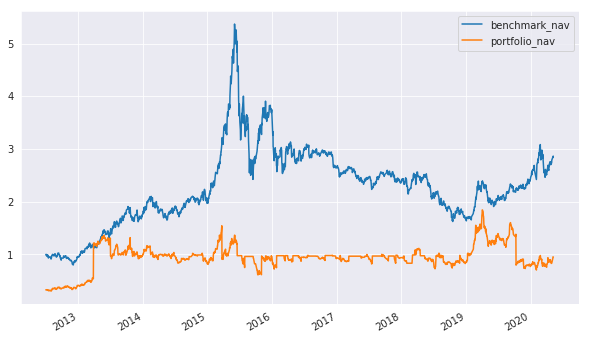

In [9]:
record_data = stragy_m.get_record()
benchmark_data = stragy_m.get_stock_base_data(benchmark_index, start_date=start_date, end_date = end_date)['close']  # 获取股票价格
benchmark_nav = benchmark_data / benchmark_data[0]
portfolio = pd.DataFrame(index=benchmark_nav.index, columns=['benchmark_nav', 'portfolio_nav'])
portfolio['benchmark_nav'] = benchmark_nav.values
portfolio['portfolio_nav'] = record_data['nav'].values
portfolio[['benchmark_nav', 'portfolio_nav']].plot(figsize=(10, 6))

In [1]:
import pandas as pd
import matplotlib.pyplot  as plt
import numpy as np
plt.rcParams['font.sans-serif']=['SimHei']

In [2]:
cyb = pd.read_csv('C:/Users/Administrator/Documents/step/cyb.csv') 
cyb_income = cyb.income
grow380 = pd.read_csv('C:/Users/Administrator/Documents/step/grow380.csv') 
grow380_income = grow380.income
hs300 = pd.read_csv('C:/Users/Administrator/Documents/step/hs300.csv') 
hs300_income = hs300.income
value_180 = pd.read_csv('C:/Users/Administrator/Documents/step/value_180.csv') 
value_180_income = value_180.income
value380 = pd.read_csv('C:/Users/Administrator/Documents/step/value380.csv') 
value380_income = value380.income
grow180 = pd.read_csv('C:/Users/Administrator/Documents/step/grow180.csv') 
grow180.set_index('Id',inplace = True)
x_index = grow180.index
grow_180_income = grow180.income

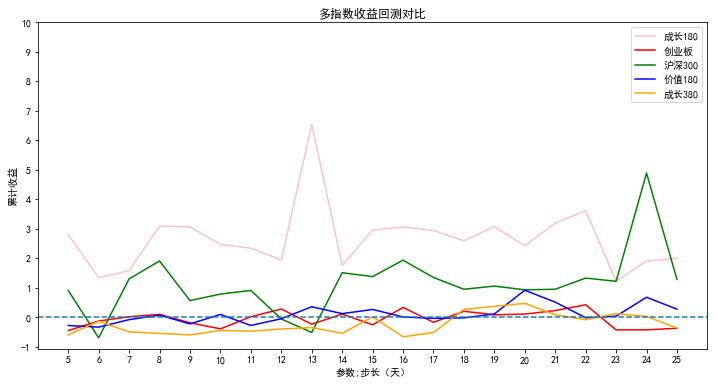

In [3]:
#参数调优，调仓步长范围5-25，以步长为变量，策略收益为因变量
plt.figure(figsize=(12,6))
plt.plot(x_index, grow_180_income, color='pink', label='成长180')
plt.plot(x_index, cyb_income, color='red', label='创业板')
plt.plot(x_index, hs300_income, color='green', label='沪深300')
plt.plot(x_index, value_180_income, color='blue', label='价值180')
plt.plot(x_index, grow380_income, color='orange', label='成长380')
plt.axhline(0,ls='--')
plt.title('多指数收益回测对比')
plt.xlabel('参数;步长（天）')
plt.ylabel('累计收益')
plt.xticks(np.arange(5,26,1),np.arange(5,26,1))
plt.yticks(np.arange(-1,11,1),np.arange(-1,11,1))
plt.legend()